In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
import catboost as cat
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap
import re

base_dir = 'data/'

import os

for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.linear_model import LinearRegression
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from datetime import datetime
import gc
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 1000)

data/sample_submission.csv
data/reduce_test.csv
data/train_labels.csv
data/test.csv
data/data-science-bowl-2019.zip
data/reduce_train.csv
data/train.csv
data/specs.csv


In [2]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv(base_dir + 'train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv(base_dir + 'test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv(base_dir + 'train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv(base_dir + 'specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv(base_dir + 'sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

train, test, train_labels, specs, sample_submission = read_data()

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [3]:
train.installation_id.unique().shape

(17000,)

In [4]:
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 11)

In [5]:
train.installation_id.unique().shape

(3614,)

In [6]:
#Credits go to Andrew Lukyanenko

def encode_title(train, test, train_labels):
    # encode title
    # 将title和event_code拼接起来
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    
    # 找到train和test都有的title_event_code，一共有398个，test只有384个，少了14个
    # {'Air Show_4080',
    #  'Bubble Bath_4080',
    #  'Bug Measurer (Activity)_4080',
    #  'Cart Balancer (Assessment)_4080',
    #  'Chest Sorter (Assessment)_4080',
    #  'Dino Dive_4080',
    #  'Dino Drink_4080',
    #  'Egg Dropper (Activity)_4080',
    #  'Fireworks (Activity)_4080',
    #  'Happy Camel_4080',
    #  'Leaf Leader_4080',
    #  'Mushroom Sorter (Assessment)_4080',
    #  'Pan Balance_4080',
    #  'Watering Hole (Activity)_2010'}
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    
    # make a list with all the unique 'titles' from the train and test set
    # 找到train和test都有的title，一共有44个
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    
    # make a list with all the unique 'event_code' from the train and test set
    # 找到train和test都有的event_code，一共有42个
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    
    # 找到train和test都有的event_id, 一共有379个，test只有365个，少了14个
    # {'01ca3a3c',
    #  '0ce40006',
    #  '119b5b02',
    #  '13f56524',
    #  '1b54d27f',
    #  '29a42aea',
    #  '2ec694de',
    #  '611485c5',
    #  '7fd1ac25',
    #  'ab4ec3a4',
    #  'bfc77bd6',
    #  'dcb1663e',
    #  'e4d32835',
    #  'ecc6157f'}
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    
    # make a list with all the unique worlds from the train and test set
    # 找到train和test共有的world，一共有4个
    # ['MAGMAPEAK', 'CRYSTALCAVES', 'TREETOPCITY', 'NONE']
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    
    # create a dictionary numerating the titles
    # 建立title(activity)和索引的键值对
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    
    # 建立索引和title(activate)的键值对
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    
    # 建立world和索引的键值对
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    
    # 找到train和test含accessment的type的title
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    
    # replace the text titles with the number titles from the dict
    # 将train、test和train_labels的title原值用键值对的索引来表示
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train_labels['title'] = train_labels['title'].map(activities_map)
    
    # 将train和test的world的原值用键值对的索引来表示
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    
    # 建立了一个{0:4100, 1:4100, ... 43:4100}的键值对
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    # 要把'Bird Measurer (Assessment)'的键值对值改成4110
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    
    # convert text into datetime
    # 用pandas的datatime的方式返回了原来的时间戳
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    # 返回了修改后的train、test、train_labels、title和event_code的键值对、共有的event_code，索引和title(activate)的键值对，含accessment的title，共有的event_code，title和event_code的拼接
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

# get usefull dict with maping encode
train, test, train_labels, win_code, \
list_of_user_activities, list_of_event_code, \
activities_labels, assess_titles, list_of_event_id,\
all_title_event_code = encode_title(train, test, train_labels)

In [7]:
activity_game_titles = ['All Star Sorting', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Air Show', 'Crystals Rule', 'Bug Measurer (Activity)', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Watering Hole (Activity)', 'Dino Drink', 'Bubble Bath', 'Bottle Filler (Activity)', 'Dino Dive', 'Chow Time', 'Chicken Balancer (Activity)', 'Happy Camel', 'Leaf Leader', 'Pan Balance', 'Egg Dropper (Activity)']
game_titles = ['All Star Sorting', 'Air Show', 'Crystals Rule', 'Scrub-A-Dub', 'Dino Drink', 'Bubble Bath', 'Dino Dive', 'Chow Time', 'Happy Camel', 'Leaf Leader', 'Pan Balance']
media_sequence = {'Welcome to Lost Lagoon!': 19, 'Tree Top City - Level 1':17, 'Ordering Spheres':61, 'Costume Box':61,'12 Monkeys':109, 'Tree Top City - Level 2':25, "Pirate's Tale":80, 
                  'Treasure Map':156, 'Tree Top City - Level 3':26, 'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18, 
                  'Balancing Act':72,'Lifting Heavy Things':118, 'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19, 'Heavy, Heavier, Heaviest':61}

In [8]:
len(list_of_user_activities), len(activity_game_titles), len(game_titles)

(44, 19, 11)

In [9]:
def cnt_miss(df):
    cnt = 0
    for e in range(len(df)):
        x = df['event_data'].iloc[e]
        y = json.loads(x)['misses']
        cnt += y
    return cnt

def get_4020_acc(df,counter_dict):
    
    for e in ['Cauldron Filler (Assessment)','Bird Measurer (Assessment)','Mushroom Sorter (Assessment)','Chest Sorter (Assessment)']:
        
        Assess_4020 = df[(df.event_code == 4020) & (df.title==activities_map[e])]   
        true_attempts_ = Assess_4020['event_data'].str.contains('true').sum()
        false_attempts_ = Assess_4020['event_data'].str.contains('false').sum()

        measure_assess_accuracy_ = true_attempts_/(true_attempts_+false_attempts_) if (true_attempts_+false_attempts_) != 0 else 0
        counter_dict[e+"_4020_accuracy"] += (counter_dict[e+"_4020_accuracy"] + measure_assess_accuracy_) / 2.0
    
    return counter_dict

In [10]:
# this is the function that convert the raw data into processed features
# 用来提取一个installation_id的特征
def get_data(user_sample, test_set=False):
    all_assessments = []
    last_activity = 0
    
    user_type_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0} # 单设备type统计，不区分title，递增性
    
    # event_count
    Assessment_mean_event_count = 0  # 单设备评估的平均事件数
    Game_mean_event_count = 0   # 单设备游戏的平均事件数
    Activity_mean_event_count = 0 # 单设备活动的平均事件数
    # game
    accumulated_game_miss = 0     
    mean_game_round = 0         # 单设备平均游戏回合  
    mean_game_duration = 0      # 单设备平均游戏持续事件 
    mean_game_level = 0         # 单设备平均游戏等级
    # 用于统计准确率的频次
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}  # 单设备准确率统计，不区分title，递增性
    accumulated_accuracy_group = 0  # 单设备准确率平均得分，不区分title，递增性
    accumulated_accuracy = 0        # 单设备准确率平均值，不区分title
    accumulated_correct_attempts = 0  # 单设备累计正确尝试
    accumulated_uncorrect_attempts = 0  # 单设备累计错误尝试
    accumulated_actions = 0   # 单设备累计动作
    
    counter = 0    # 评估的次数
    sessions_count = 0    # session的次数
    
    # 
    positive_words = "play again|did it|job|wow|cool|nice|amazing|exactly|Great|awe|That's it|just right|good|Alright|gold|That's right|All right|right amount|Well done|you're right|happy|won|Whoa"
    negative_words = "try again|too|Almost|n't|but|Whoops|Oops|not right|Uh oh"
    accumulated_positive_events = 0
    accumulated_negative_events = 0
    accumulated_positive_title = {'accumulated_positive_'+t: 0 for t in activity_game_titles}
    accumulated_negative_title = {'accumulated_negative_'+t: 0 for t in activity_game_titles}
    accumulated_positive_title_ratio = {'accumulated_positive_ratio_'+t: 0 for t in activity_game_titles}
    accumulated_negative_title_ratio = {'accumulated_negative_ratio_'+t: 0 for t in activity_game_titles}
    accumulated_won_game = {'accumulated_won_game_count_'+g: 0 for g in game_titles}
    
#     time_spent_each_act = {t+"_time": 0 for t in list_of_user_activities}
#     time_spent_each_acts = {t+"_time": [] for t in list_of_user_activities}
#     time_spent_each_act_mean = {t+"_time_mean": 0 for t in list_of_user_activities}
    
    # 时间
    durations = []
    clip_durations = []       # 单设备视频时长
    Activity_durations = []   # 单设备活动时长
    Game_durations = []      # 单设备游戏时长
    
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}   # 上一次title_accessment的准确率
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code} # 单设备event_code的统计
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}   # 单设备event_id的统计
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()}    # 单设备title统计
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code} # 单设备title_event_code统计
    
    # 根据Assessment
    type_count_clip = {'clip_' + title: 0 for title in assess_titles}
    type_count_activity = {'activity' + title: 0 for title in assess_titles}
    type_count_assessment = {'assessment' + title: 0 for title in assess_titles}
    type_count_game = {'game' + title: 0 for title in assess_titles}
    
    
    # i 是game_session, session 是 game_session中的一行，并且按照时间顺序
    for i, session in user_sample.groupby('game_session', sort=False): 
        # 取了type、title的键值对和文字
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
        
        if(session_type=='Game' or session_type=='Activity'):
#             time_spent = (session.iloc[-1, 2] - session.iloc[0, 2]).seconds
#             time_spent_each_act[session_title_text + "_time"] += time_spent
#             time_spent_each_acts[session_title_text + "_time"].append(time_spent)
#             time_spent_each_acts[session_title_text + "_time"].append(time_spent)

            sum_positive_events = session['event_data'].str.contains(positive_words, flags=re.IGNORECASE).sum()
            sum_negative_events = session['event_data'].str.contains(negative_words, flags=re.IGNORECASE).sum()
            accumulated_positive_events += sum_positive_events
            accumulated_negative_events += sum_negative_events
            accumulated_positive_title['accumulated_positive_'+session_title_text] += sum_positive_events
            accumulated_negative_title['accumulated_negative_'+session_title_text] += sum_negative_events
            p = accumulated_positive_title['accumulated_positive_'+session_title_text]
            n = accumulated_negative_title['accumulated_negative_'+session_title_text]
            accumulated_positive_title_ratio['accumulated_positive__ratio_'+session_title_text] = p/(p+n) if (p+n)>0 else 0
            accumulated_negative_title_ratio['accumulated_negative__ratio_'+session_title_text] = n/(p+n) if (p+n)>0 else 0
        
        if(session_type=='Clip'):
            clip_durations.append((media_sequence[activities_labels[session_title]]))
#             time_spent = media_sequence[session_title_text]
#             time_spent_each_act[session_title_text + "_time"] += time_spent
#             time_spent_each_acts[session_title_text + "_time"].append(time_spent)
        elif(session_type=='Activity'):
            Activity_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1])/2.0
        elif (session_type == 'Game'):
            game_s = session[session.event_code == 2030]   
            misses_cnt = cnt_miss(game_s)        
            accumulated_game_miss += misses_cnt 
            
            accumulated_won_game['accumulated_won_game_count_'+session_title_text]+=session['event_data'].str.contains('play again', flags=re.IGNORECASE).sum()
            
            Game_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1])/2.0
            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                mean_game_round =  (mean_game_round + game_round)/2.0  # ？？？ 啥计算
            except:
                pass
            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                mean_game_round =  (mean_game_round + game_round)/2.0
            except:
                pass
            try:
                game_duration = json.loads(session['event_data'].iloc[-1])["duration"]
                mean_game_duration = (mean_game_duration + game_duration) /2.0
            except:
                pass
            try:
                game_level = json.loads(session['event_data'].iloc[-1])["level"]
                mean_game_level = (mean_game_level + game_level) /2.0
            except:
                pass
        
        # 如果是评估类而且有多条记录，并且是，测试集或者是有多条记录的game_session，否则只有一条的评估不能产生价值？
        # Assessment 改进猜想：根据Assessment title来评估
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            
            # 找 4100 或者 (bird是4110)的记录，这是一条尝试评估, game_session对应唯一的title、type、world
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            
            # 累加尝试评估后正确或者错误的次数
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            
            # 单设备评估
            features = user_type_count.copy()
            features.update(last_accuracy_title.copy()) # （if delete:这是先验了上一次没有先验上几次评估，并且没有评估title）
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            
            # 积极和消极词汇
            features.update(accumulated_positive_title)
            features.update(accumulated_negative_title)
            features.update(accumulated_positive_title_ratio)
            features.update(accumulated_negative_title_ratio)
            
            features.update(accumulated_won_game.copy())
            
             # 唯一标识
            features['installation_id'] = session['installation_id'].iloc[-1]
            features['session_title'] = session['title'].iloc[0]
            
            # session
            features['installation_session_count'] = sessions_count
            
            # 事件数
            features['Assessment_mean_event_count'] = Assessment_mean_event_count
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            
            # 游戏
            features['accumulated_game_miss'] = accumulated_game_miss
            features['mean_game_round'] = mean_game_round
            features['mean_game_duration'] = mean_game_duration
            features['mean_game_level'] = mean_game_level
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)

            # positive & negative events
            features['accumulated_positive_events'] = accumulated_positive_events
            features['accumulated_negative_events'] = accumulated_negative_events
            positive_negative_events = accumulated_positive_events + accumulated_negative_events
            features['positive_events_ratio'] = accumulated_positive_events/positive_negative_events if positive_negative_events > 0 else 0
            features['negative_events_ratio'] = accumulated_negative_events/positive_negative_events if positive_negative_events > 0 else 0
            accumulated_positive_events = 0
            accumulated_negative_events = 0    
                
            # the accurace is the all time wins divided by the all time attempts
            # 计算本次评估的准确率
            accuracy = true_attempts/(true_attempts + false_attempts) if (true_attempts + false_attempts) != 0 else 0
            last_accuracy_title['acc_' + session_title_text] = accuracy
            
            Assessment_mean_event_count = (Assessment_mean_event_count + session['event_count'].iloc[-1])/2.0
            
            # 导出accuracy_group(labels)的方法
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else: # accuracy == 1 / 3
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            
            #持续时间
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            if clip_durations == []:
                features['Clip_duration_mean'] = 0
                features['Clip_duration_std'] = 0
            else:
                features['Clip_duration_mean'] = np.mean(clip_durations)
                features['Clip_duration_std'] = np.std(clip_durations)
            if Activity_durations == []:
                features['Activity_duration_mean'] = 0
                features['Activity_duration_std'] = 0
            else:
                features['Activity_duration_mean'] = np.mean(Activity_durations)
                features['Activity_duration_std'] = np.std(Activity_durations)
            if Game_durations == []:
                features['Game_duration_mean'] = 0
                features['Game_duration_std'] = 0
            else:
                features['Game_duration_mean'] = np.mean(Game_durations)  # 游戏平均时间
                features['Game_duration_std'] = np.std(Game_durations)    # 游戏时间方差
                
#             time_spent = (session.iloc[-1, 2] - session.iloc[0, 2]).seconds
#             time_spent_each_act[session_title_text + "_time"] += time_spent
#             time_spent_each_acts[session_title_text + "_time"].append(time_spent)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)
            
            # 累计正确和错误的尝试
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts
            accumulated_uncorrect_attempts += false_attempts
            # 准确率平均值 = (准确率 + 准确率 ...) / n
            # features['accumulated_accuracy'] = accumulated_accuracy / counter if counter > 0 else 0
            # accumulated_accuracy += accuracy
            # 准确率的平均得分  (得分 + 得分 ...) / n
            features['accumulated_accuracy_group'] = accumulated_accuracy_group / counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            
            counter += 1   # 评估次数
        
            features['accumulated_actions'] = accumulated_actions # 累计动作
            
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter     
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        sessions_count += 1
        
        accumulated_actions += len(session)
        if last_activity != session_type: # 感觉这个判断可以删除
            user_type_count[session_type] += 1
            last_activitiy = session_type         
                
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [11]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (installation_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
#         break; # debug
    for installation_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
#         break; # debug
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [12]:
reduce_train.shape

(17690, 1032)

In [13]:
reduce_train.head()

,Clip,Activity,Assessment,Game,acc_Mushroom Sorter (Assessment),acc_Cauldron Filler (Assessment),acc_Cart Balancer (Assessment),acc_Chest Sorter (Assessment),acc_Bird Measurer (Assessment),2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,acf5c23f,c0415e5c,363c86c9,bb3e370b,b5053438,923afab1,1beb320a,3ccd3f02,0ce40006,15a43e5b,1340b8d7,dcb55a27,37937459,119b5b02,6f4bd64e,6c930e6e,d51b1749,7da34a02,5b49460a,d06f75b5,28f975ea,c58186bf,77261ab5,f50fc6c1,7f0836bf,e5734469,9d29771f,bfc77bd6,b012cd7f,3323d7e9,1b54d27f,7ab78247,0db6d71d,b120f2ac,7ad3efc6,86ba578b,93edfe2e,85de926c,b80e5e84,30df3273,56817e2b,28a4eb9a,9ed8f6da,a1192f43,d88e8f25,2b9272f4,6bf9e3e1,28ed704e,13f56524,1c178d24,ecc36b7f,47f43a44,155f62a4,c7128948,4bb2f698,a29c5338,b88f38da,26fd2d99,6088b756,c7fe2a55,9b01374f,29bdd9ba,15f99afc,eb2c19cd,90d848e0,a1bbe385,250513af,5859dfb6,28520915,08ff79ad,56cd3b43,ad2fc29c,bd612267,99abe2bb,87d743c1,e37a2b78,cdd22e43,16667cc5,1375ccb7,3d63345e,3bb91ced,c6971acf,f6947f54,bd701df8,a16a373e,5f0eb72c,587b5989,d3f1e122,5c3d2b2f,ec138c1c,9e4c8c7b,00c73085,3babcb9b,9e6b7fb5,795e4a37,47026d5f,84b0e0c8,461eace6,e694a35b,ac92046e,a6d66e51,a76029ee,e3ff61fb,88d4a5be,c51d8688,cf7638f3,3afb49e6,53c6e11a,abc5811c,cf82af56,6aeafed4,5e812b27,6d90d394,a0faea5d,a8876db3,a44b10dc,ecaab346,3bf1cf26,9de5e594,5be391b5,022b4259,d2278a3b,6077cc36,beb0a7b9,86c924c4,51102b85,3d8c61b0,58a0de5c,3a4be871,bcceccc6,ea296733,ab3136ba,de26c3a6,d88ca108,363d3849,c1cac9a2,90efca10,2dcad279,7ec0c298,f54238ee,3d0b9317,db02c830,7525289a,7040c096,0413e89d,67aa2ada,65a38bf7,2b058fe3,cc5087a3,6043a2b4,a7640a16,06372577,29f54413,8af75982,37ee8496,15ba1109,46cd75b4,4d6737eb,d3640339,3bb91dda,69fdac0a,4c2ec19f,b2e5b0f1,907a054b,2ec694de,5f5b2617,1996c610,4901243f,dcaede90,74e5f8a7,1bb5fbdb,8d7e386c,7d093bf9,6c517a88,30614231,f71c4741,27253bdc,6f445b57,a8efe47b,828e68f9,4a09ace1,3b2048ee,731c0cbe,c54cf6c5,44cb4907,598f4598,2230fab4,5de79a6a,e7e44842,92687c59,55115cbd,2a512369,4a4c3d21,9c5ef70c,b74258a0,df4940d3,8d748b58,562cec5f,bdf49a58,29a42aea,71fe8f75,0330ab6a,e9c52111,2a444e03,1af8be29,499edb7c,4e5fc6f5,05ad839b,67439901,0a08139c,e7561dd2,bbfe0445,5d042115,1575e76c,89aace00,0d18d96c,4b5efe37,85d1b0de,84538528,1325467d,8b757ab8,e5c9df6f,6f8106d9,dcb1663e,6cf7d25c,7d5c30a2,d185d3ea,3edf6747,e57dd7af,2c4e6db0,4d911100,14de4c5d,e79f3763,f56e0afc,b2dba42b,3afde5dd,7cf1bc53,d9c005dd,0086365d,bc8f2793,99ea62f3,6f4adc4b,25fa8af4,daac11b0,070a5291,63f13dd7,3ee399c3,3dcdda7f,532a2afb,31973d56,26a5a3dd,d122731b,76babcde,ab4ec3a4,5a848010,15eb4a7d,93b353f2,857f21c0,90ea0bac,37db1c2f,e64e2cfd,19967db1,48349b14,1cc7cfca,83c6c409,d2659ab4,8ac7cce4,709b1251,9554a50b,ca11f653,51311d7a,fcfdffb6,08fd73f3,884228c8,b7dc8128,77c76bc5,df4fe8b6,cb1178ad,cb6010f8,160654fd,565a3990,d02b7a8e,d3268efa,9d4e7b25,9b4001e4,f5b8c21a,e4f1efe6,f3cd5473,611485c5,01ca3a3c,2dc29e21,c74f40cd,832735e1,1f19558b,a5e9da97,792530f8,a5be6304,71e712d8,3ddc79c3,392e14df,d45ed6a1,37c53127,65abac75,9ee1c98c,73757a5e,3dfd4aa4,8fee50e2,47efca07,b7530680,45d01abe,7372e1a5,46b50ba8,5154fc30,f806dc10,9e34ea74,7dfe6d8a,f32856e4,e080a381,a1e4395d,d2e9262e,c7f7f0e1,f7e47413,e720d930,9b23e8ee,e04fb33d,c189aaf2,5e109ec3,04df9b66,77ead60d,fd20ea40,b1d5101d,ea321fb1,9ce586dd,33505eae,7423acbc,17113b36,ad148f58,c952eb01,763fc34e,38074c54,262136f4,7961e599,222660ff,3bfd1a65,1cf54632,02a42007,3393b68b,16dffff1,56bcd38d,a52b92d5,49ed92e9,804ee27f,0d1da71f,5290eab1,36fa3ebe,ecc6157f,736f9581,c2baf0bd,4ef8cdd3,7fd1ac25,5348fd84,c277e121,5c2f29ca,a2df0760,f28c589a,5e3ea25a,a592d54e,a8a78786,8f094001,91561152,fbaf3456,e4d32835,cfbd47c8,f93fc684,d38c2fd7,895865f3,2fb91ec1,756e5507,8d84fa81,Tree Top City - Level 3,Slop Problem,Balancing Act,Happy Camel,Egg Dropper (Activity),Crystals Rule,Sandcastle Builder (Activity),Lifting Heavy Things,Chow Time,Chest Sorter (Assessment),Mag

In [14]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [15]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
#             c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]   
            c = np.abs(np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1])  
            if c > 0.995:  # 相关性
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: Clip FEAT_B: 27253bdc - Correlation: 0.9999999999999999
2: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965259434878118
3: FEAT_A: 2050 FEAT_B: 2b9272f4 - Correlation: 0.9999839030068793
4: FEAT_A: 2050 FEAT_B: 26fd2d99 - Correlation: 0.9965084543995759
5: FEAT_A: 2050 FEAT_B: dcaede90 - Correlation: 0.9965259434878118
6: FEAT_A: 2050 FEAT_B: 08fd73f3 - Correlation: 0.9966123918733654
7: FEAT_A: 2050 FEAT_B: 37c53127 - Correlation: 1.0
8: FEAT_A: 2050 FEAT_B: 73757a5e - Correlation: 0.9998050146713992
9: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3121 - Correlation: 0.9999839030068793
10: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2030 - Correlation: 0.9966123918733654
11: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2040 - Correlation: 0.9965259434878118
12: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2050 - Correlation: 1.0
13: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2020 - Correlation: 0.9965084543995759
14: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3021 - Correlation: 0.9998050146713992
15: FEAT_A: 2050 FEAT_B: accumulated_positi

114: FEAT_A: 1b54d27f FEAT_B: Watering Hole (Activity)_2010 - Correlation: 1.0
115: FEAT_A: 7ab78247 FEAT_B: b80e5e84 - Correlation: 0.9998336590281087
116: FEAT_A: 7ab78247 FEAT_B: Egg Dropper (Activity)_3110 - Correlation: 0.9998336590281087
117: FEAT_A: 7ab78247 FEAT_B: Egg Dropper (Activity)_3010 - Correlation: 1.0
118: FEAT_A: 0db6d71d FEAT_B: Chest Sorter (Assessment)_4020 - Correlation: 1.0
119: FEAT_A: b120f2ac FEAT_B: d45ed6a1 - Correlation: 0.9979707847816691
120: FEAT_A: b120f2ac FEAT_B: c277e121 - Correlation: 0.9999983835744553
121: FEAT_A: b120f2ac FEAT_B: All Star Sorting_3020 - Correlation: 0.9999983835744553
122: FEAT_A: b120f2ac FEAT_B: All Star Sorting_3120 - Correlation: 0.9979707847816691
123: FEAT_A: b120f2ac FEAT_B: All Star Sorting_2025 - Correlation: 1.0
124: FEAT_A: b120f2ac FEAT_B: accumulated_negative_All Star Sorting - Correlation: 0.9995085114845523
125: FEAT_A: 7ad3efc6 FEAT_B: 65a38bf7 - Correlation: 0.999978626569043
126: FEAT_A: 7ad3efc6 FEAT_B: Cart B

218: FEAT_A: 795e4a37 FEAT_B: Cart Balancer (Assessment)_3010 - Correlation: 1.0
219: FEAT_A: 84b0e0c8 FEAT_B: ea321fb1 - Correlation: 0.9993007600205109
220: FEAT_A: 84b0e0c8 FEAT_B: Chicken Balancer (Activity)_3110 - Correlation: 1.0
221: FEAT_A: 84b0e0c8 FEAT_B: Chicken Balancer (Activity)_3010 - Correlation: 0.9993007600205109
222: FEAT_A: 461eace6 FEAT_B: Egg Dropper (Activity)_4020 - Correlation: 1.0
223: FEAT_A: e694a35b FEAT_B: Fireworks (Activity)_4020 - Correlation: 1.0
224: FEAT_A: a76029ee FEAT_B: Bird Measurer (Assessment)_4040 - Correlation: 0.9999999999999999
225: FEAT_A: e3ff61fb FEAT_B: 709b1251 - Correlation: 0.9995444786291265
226: FEAT_A: e3ff61fb FEAT_B: Dino Dive_3121 - Correlation: 0.9995444786291265
227: FEAT_A: e3ff61fb FEAT_B: Dino Dive_3021 - Correlation: 1.0
228: FEAT_A: 88d4a5be FEAT_B: 160654fd - Correlation: 0.998929717261588
229: FEAT_A: 88d4a5be FEAT_B: Mushroom Sorter (Assessment)_3120 - Correlation: 1.0
230: FEAT_A: 88d4a5be FEAT_B: Mushroom Sorter (A

324: FEAT_A: 828e68f9 FEAT_B: Cart Balancer (Assessment)_3110 - Correlation: 1.0
325: FEAT_A: 4a09ace1 FEAT_B: Scrub-A-Dub_2083 - Correlation: 1.0
326: FEAT_A: 3b2048ee FEAT_B: Leaf Leader_4095 - Correlation: 1.0
327: FEAT_A: 731c0cbe FEAT_B: Bird Measurer (Assessment)_4090 - Correlation: 1.0
328: FEAT_A: 44cb4907 FEAT_B: 8b757ab8 - Correlation: 0.999835058794711
329: FEAT_A: 44cb4907 FEAT_B: Crystals Rule_3120 - Correlation: 0.999835058794711
330: FEAT_A: 44cb4907 FEAT_B: Crystals Rule_3020 - Correlation: 1.0
331: FEAT_A: 598f4598 FEAT_B: Flower Waterer (Activity)_4025 - Correlation: 0.9999999999999998
332: FEAT_A: 2230fab4 FEAT_B: 0330ab6a - Correlation: 0.9998673365188064
333: FEAT_A: 2230fab4 FEAT_B: Chow Time_3020 - Correlation: 0.9998673365188064
334: FEAT_A: 2230fab4 FEAT_B: Chow Time_3120 - Correlation: 0.9999999999999999
335: FEAT_A: 5de79a6a FEAT_B: 31973d56 - Correlation: 0.9973945339840646
336: FEAT_A: 5de79a6a FEAT_B: Cart Balancer (Assessment)_3020 - Correlation: 1.0
337:

430: FEAT_A: 9d4e7b25 FEAT_B: Cart Balancer (Assessment)_4040 - Correlation: 1.0
431: FEAT_A: f3cd5473 FEAT_B: Pan Balance_4070 - Correlation: 1.0
432: FEAT_A: 611485c5 FEAT_B: Fireworks (Activity)_4080 - Correlation: 1.0
433: FEAT_A: 01ca3a3c FEAT_B: Leaf Leader_4080 - Correlation: 0.9999999999999999
434: FEAT_A: 2dc29e21 FEAT_B: All Star Sorting_4020 - Correlation: 1.0
435: FEAT_A: a5e9da97 FEAT_B: Pan Balance_4100 - Correlation: 1.0
436: FEAT_A: 792530f8 FEAT_B: Dino Drink_4030 - Correlation: 1.0
437: FEAT_A: 392e14df FEAT_B: Cauldron Filler (Assessment)_4100 - Correlation: 1.0
438: FEAT_A: 65abac75 FEAT_B: Air Show_4010 - Correlation: 1.0
439: FEAT_A: 9ee1c98c FEAT_B: Sandcastle Builder (Activity)_4021 - Correlation: 0.9999999999999999
440: FEAT_A: 8fee50e2 FEAT_B: Bird Measurer (Assessment)_4020 - Correlation: 1.0
441: FEAT_A: 47efca07 FEAT_B: Bottle Filler (Activity)_4090 - Correlation: 1.0
442: FEAT_A: 7372e1a5 FEAT_B: Chow Time_4070 - Correlation: 1.0
443: FEAT_A: 46b50ba8 FEAT

In [16]:
len(features)

975

In [17]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)
    if 

Clip 34.06529112492934 15.253
Activity 10.746410401356698 4.726
Assessment 7.8468626342566425 2.347
Game 12.502939513849633 5.119
acc_Mushroom Sorter (Assessment) -0.11320835577336426 -0.5178321428571429
acc_Cauldron Filler (Assessment) -0.085827225032991 -0.48076626984126986
acc_Cart Balancer (Assessment) -0.04020325710970143 -0.47065833333333335
acc_Chest Sorter (Assessment) -0.44928792877366747 -0.7507142857142858
acc_Bird Measurer (Assessment) -0.43114150123580086 -0.7215188741813743
2050 7.501356698699831 2.862
4100 26.189881288863766 7.284
4230 8.124816280384398 3.4
5000 4.9399660825325045 2.273
4235 8.123685698134539 3.4
2060 3.9443188241944602 1.614
4110 6.011588468061052 1.32
5010 4.828547201808932 2.215
2070 2.0806105144149236 0.843
2075 1.622215941209723 0.682
2080 8.874053137365744 3.467
2081 2.1376483889202937 0.876
2083 6.166817410966648 2.412
3110 346.88004522329 140.268
4010 12.74120972300735 5.193
3120 70.54013566986998 26.494
3121 66.57071791972866 25.679
4020 306.726

e7561dd2 7.664047484454494 2.693
bbfe0445 11.57976257772753 4.852
5d042115 23.125777275296777 10.917
1575e76c 2.20192198982476 0.654
89aace00 1.6400791407574902 0.791
0d18d96c 0.14516676088185415 0.018
4b5efe37 1.257207461842849 0.548
85d1b0de 0.18501978518937254 0.107
84538528 9.03408705483324 3.941
1325467d 39.23403052572075 23.457
8b757ab8 2.761390616167326 0.906
e5c9df6f 1.458846806105144 0.567
6f8106d9 0.05703787450537027 0.022
dcb1663e 0.0 0.0
6cf7d25c 5.647145279819107 2.068
7d5c30a2 0.9420576596947428 0.429
d185d3ea 10.552176370830978 5.245
3edf6747 1.3747880158281516 0.347
e57dd7af 3.0602600339174675 1.101
2c4e6db0 4.099095534200113 1.765
4d911100 8.940418315432447 3.844
14de4c5d 3.0086489542114188 0.773
e79f3763 14.515488976823065 7.309
f56e0afc 1.1471452798191069 0.327
b2dba42b 29.667552289429057 13.016
3afde5dd 1.48208027133974 0.584
7cf1bc53 6.137931034482759 1.91
d9c005dd 1.1859242509892596 0.458
0086365d 0.8116449971735443 0.326
bc8f2793 2.6219898247597513 1.087
99ea62f3

Happy Camel_3110 10.666139061616732 4.561
Bottle Filler (Activity)_3010 29.3791972866026 14.423
Bird Measurer (Assessment)_2020 1.6508196721311474 0.535
All Star Sorting_3120 1.5201808931599774 0.683
Air Show_3120 1.096664782362917 0.223
All Star Sorting_4030 21.927077444884116 9.652
Dino Drink_3120 1.6400791407574902 0.791
Dino Dive_2030 3.065856416054268 1.292
Cauldron Filler (Assessment)_3110 8.431995477671 2.31
Dino Dive_2020 3.521254946297343 1.51
Happy Camel_2081 0.5529677784058791 0.207
Happy Camel_4035 0.3793103448275862 0.147
Mushroom Sorter (Assessment)_2010 1.187337478801583 0.36
Air Show_2000 0.9531938948558507 0.318
Bug Measurer (Activity)_3010 42.689881288863766 19.188
Dino Dive_2000 1.0188807235726398 0.461
Cart Balancer (Assessment)_2020 1.6141888072357264 0.565
Sandcastle Builder (Activity)_3010 29.667552289429057 13.016
Chicken Balancer (Activity)_4080 0.027586206896551724 0.016
Dino Drink_2020 3.19672131147541 1.439
Bug Measurer (Activity)_4035 7.218089315997739 4.18

Bug Measurer (Activity)_4030 14.515488976823065 7.309
Cart Balancer (Assessment)_2010 1.1257207461842849 0.396
Cart Balancer (Assessment)_4070 6.951667608818542 2.681
Chest Sorter (Assessment)_2020 1.3233465234595816 0.359
Dino Drink_4030 14.781062747314866 7.126
Dino Drink_3020 1.647880158281515 0.795
Pan Balance_3021 4.573318258903336 1.528
Dino Drink_4080 0.0009044657998869418 0.0
Bubble Bath_4045 2.1918598078010176 1.073
Chow Time_4095 0.9591859807801018 0.539
Dino Dive_4010 1.042736009044658 0.467
Chest Sorter (Assessment)_3020 3.0655737704918034 0.84
Cauldron Filler (Assessment)_4030 11.815093273035613 3.345
Crystals Rule_2030 5.75008479366874 1.75
Chest Sorter (Assessment)_3110 4.175409836065573 1.124
Crystals Rule_3010 35.79564725833804 11.004
Crystals Rule_4020 8.344827586206897 2.554
Chest Sorter (Assessment)_3021 0.8537591859807802 0.214
Bubble Bath_4080 0.004070096099491238 0.0
Dino Drink_4031 11.599152063312607 5.267
Mushroom Sorter (Assessment)_2000 1.9789146410401357 0.5

accumulated_negative__ratio_Crystals Rule 0.3585902600157675 0.3316843934275342


In [18]:
features_copy = features.copy()
# features_copy = [x for x in features if x not in (to_exclude)]
reduce_train[features_copy].shape, ajusted_test.shape, len(features_copy), categoricals

((17690, 975), (1000, 1032), 975, ['session_title'])

In [19]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod(
            (datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [50]:
# solve: LightGBMError: Do not support special JSON characters in feature name.
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]
features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]


def LGB_CV(
          max_depth,
          learning_rate,

          colsample_bytree,
            reg_alpha,
            reg_lambda,
            num_leaves,
#           bagging_freq,    
    
          feature_fraction,
          bagging_fraction,
          lambda_l1,
          lambda_l2,
          target='accuracy_group',
          categoricals=['session_title']
         ):
    train_df = reduce_train

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
#     folds = GroupKFold(n_splits=5)
    
    cv = folds.split(reduce_train, reduce_train[target])
    
    param = {
        'objective':'regression',
        "boosting_type": "gbdt",
        'metric': 'rmse',
        'eval_metric': 'cappa',

        'early_stopping_rounds': 300,
        "verbosity": -1,
        'is_unbalance': False,
        'subsample': 1,
        'subsample_for_bin': 24000,
        'seed': 42,
        'num_leaves':int(num_leaves),
        'max_depth': int(max_depth),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'colsample_bytree': colsample_bytree,
        'learning_rate': learning_rate,
        
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
#         'verbose': 100,
#         'bagging_freq': int(bagging_freq),
        "feature_fraction": feature_fraction,
        "bagging_fraction": bagging_fraction,
        "lambda_l1": lambda_l1,
        "lambda_l2": lambda_l2,
    }
    
    
    oof_pred = np.zeros(train_df.shape[0])
    for fold, (train_idx, val_idx) in enumerate(cv):
        
        x_train, x_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]   
        y_train, y_val = train_df[target][train_idx], train_df[target][val_idx]

        train_set = lgb.Dataset(x_train, y_train, categorical_feature=categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=categoricals)
        
        clf = lgb.train(param, train_set, 10000, valid_sets = [train_set, val_set], verbose_eval=100, early_stopping_rounds=100)
        
        oof_pred[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
        
        print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        
        del clf, train_idx, val_idx
        gc.collect()
    _, loss_score, _ = eval_qwk_lgb_regr(train_df[target], oof_pred)    
    print('Our oof cohen kappa score is: ', loss_score)
    # return -mean_squared_error(oof, target)**0.5
    return loss_score

LGB_BO = BayesianOptimization(LGB_CV, {
    'max_depth': (8, 12),
    'learning_rate': (0.025, 0.1),
    'colsample_bytree': (0.4, 0.6),
    'num_leaves':(10, 100),
    'reg_alpha': (0.4, 0.6),
    'reg_lambda': (0.4, 0.6),
    'feature_fraction': (0.4, 1.0),
    'bagging_fraction': (0.4, 1.0),
    'lambda_l1': (0, 6),
    'lambda_l2': (0, 6),
#     'bagging_freq': (1, 10),
    })

print('-'*126)

start_time = timer(None)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0, random_state=1000)
timer(start_time)

------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.842621	valid_1's rmse: 0.999732
[200]	training's rmse: 0.755469	valid_1's rmse: 1.00564
[300]	training's rmse: 0.69164	valid_1's rmse: 1.01114
Early stopping, best iteration is:
[79]	training's rmse: 0.866086	valid_1's rmse: 0.998685
Partial score of fold 0 is: 0.5741360331630556
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.845501	valid_1's rmse: 0.990729
[200]	training's rmse: 0.755406	valid_1's rmse: 0.994568
[300]	training's rmse: 0.687875	valid

Early stopping, best iteration is:
[108]	training's rmse: 0.753013	valid_1's rmse: 0.984589
Partial score of fold 1 is: 0.5981132481026146
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.770953	valid_1's rmse: 0.980954
[200]	training's rmse: 0.654723	valid_1's rmse: 0.983095
[300]	training's rmse: 0.575298	valid_1's rmse: 0.986609
[400]	training's rmse: 0.514103	valid_1's rmse: 0.990465
Early stopping, best iteration is:
[120]	training's rmse: 0.743466	valid_1's rmse: 0.979562
Partial score of fold 2 is: 0.6035359809111684
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.769513	valid_1's rmse: 0.972444
[200]	training's rmse: 0.651467	valid_1's rmse: 0.973084
[300]	training's rmse: 0.57579	valid_1's rmse: 0.975047
[400]	training's rmse: 0.518042	valid_1's rmse: 0.978955
Early stopping, best iteration is:
[148]	training's rmse: 0.705558	valid_1's rmse: 0.971519
Partial score of fold 3 is: 0.5997236580612417
Trai

Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.834648	valid_1's rmse: 1.00109
[200]	training's rmse: 0.748061	valid_1's rmse: 0.998578
[300]	training's rmse: 0.69379	valid_1's rmse: 1.00027
[400]	training's rmse: 0.651974	valid_1's rmse: 1.00224
Early stopping, best iteration is:
[141]	training's rmse: 0.787477	valid_1's rmse: 0.997188
Partial score of fold 0 is: 0.5734202954036658
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.836517	valid_1's rmse: 0.994115
[200]	training's rmse: 0.748703	valid_1's rmse: 0.989785
[300]	training's rmse: 0.69554	valid_1's rmse: 0.991478
[400]	training's rmse: 0.651398	valid_1's rmse: 0.992857
[500]	training's rmse: 0.615105	valid_1's rmse: 0.99443
Early stopping, best iteration is:
[203]	training's rmse: 0.747321	valid_1's rmse: 0.989681
Partial score of fold 1 is: 0.5855878373132928
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.8441

[300]	training's rmse: 0.455943	valid_1's rmse: 1.0034
Early stopping, best iteration is:
[67]	training's rmse: 0.749153	valid_1's rmse: 0.988476
Partial score of fold 1 is: 0.5875561161516147
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.681898	valid_1's rmse: 0.981762
[200]	training's rmse: 0.542868	valid_1's rmse: 0.988163
[300]	training's rmse: 0.457696	valid_1's rmse: 0.995383
Early stopping, best iteration is:
[61]	training's rmse: 0.768935	valid_1's rmse: 0.980621
Partial score of fold 2 is: 0.6041970190574282
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.685379	valid_1's rmse: 0.976029
[200]	training's rmse: 0.5477	valid_1's rmse: 0.983904
[300]	training's rmse: 0.462114	valid_1's rmse: 0.98954
Early stopping, best iteration is:
[43]	training's rmse: 0.817824	valid_1's rmse: 0.97459
Partial score of fold 3 is: 0.5938188215462756
Training until validation scores don't improve for 300 rounds
[100]	t

Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.942871	valid_1's rmse: 0.981324
[200]	training's rmse: 0.900753	valid_1's rmse: 0.980251
[300]	training's rmse: 0.866168	valid_1's rmse: 0.980031
[400]	training's rmse: 0.836445	valid_1's rmse: 0.981027
[500]	training's rmse: 0.808934	valid_1's rmse: 0.980764
Early stopping, best iteration is:
[267]	training's rmse: 0.876895	valid_1's rmse: 0.979474
Partial score of fold 3 is: 0.5932820182267333
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.942402	valid_1's rmse: 0.985818
[200]	training's rmse: 0.898912	valid_1's rmse: 0.984216
[300]	training's rmse: 0.863545	valid_1's rmse: 0.984379
[400]	training's rmse: 0.83398	valid_1's rmse: 0.986117
Early stopping, best iteration is:
[147]	training's rmse: 0.920826	valid_1's rmse: 0.983573
Partial score of fold 4 is: 0.5943445224768906
Our oof cohen kappa score is:  0.5893047320922497
|  14       |  0.5893   |  0.6788   

[100]	training's rmse: 0.939312	valid_1's rmse: 0.992742
[200]	training's rmse: 0.899786	valid_1's rmse: 0.988262
[300]	training's rmse: 0.868341	valid_1's rmse: 0.986924
[400]	training's rmse: 0.841831	valid_1's rmse: 0.986538
[500]	training's rmse: 0.816572	valid_1's rmse: 0.98743
[600]	training's rmse: 0.794657	valid_1's rmse: 0.988312
[700]	training's rmse: 0.773969	valid_1's rmse: 0.989435
Early stopping, best iteration is:
[410]	training's rmse: 0.839119	valid_1's rmse: 0.986251
Partial score of fold 1 is: 0.5945345593056655
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.944676	valid_1's rmse: 0.988604
[200]	training's rmse: 0.904121	valid_1's rmse: 0.985316
[300]	training's rmse: 0.872071	valid_1's rmse: 0.986012
[400]	training's rmse: 0.843796	valid_1's rmse: 0.98556
[500]	training's rmse: 0.818816	valid_1's rmse: 0.986138
Early stopping, best iteration is:
[242]	training's rmse: 0.889653	valid_1's rmse: 0.984747
Partial score of fold 2 i

Partial score of fold 1 is: 0.5938188215462756
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.92888	valid_1's rmse: 0.983954
[200]	training's rmse: 0.882532	valid_1's rmse: 0.982771
[300]	training's rmse: 0.845236	valid_1's rmse: 0.983458
[400]	training's rmse: 0.811706	valid_1's rmse: 0.985496
[500]	training's rmse: 0.782175	valid_1's rmse: 0.986793
Early stopping, best iteration is:
[233]	training's rmse: 0.869057	valid_1's rmse: 0.982149
Partial score of fold 2 is: 0.6016919368995637
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.926903	valid_1's rmse: 0.977026
[200]	training's rmse: 0.880015	valid_1's rmse: 0.973209
[300]	training's rmse: 0.842478	valid_1's rmse: 0.974203
[400]	training's rmse: 0.80977	valid_1's rmse: 0.973385
Early stopping, best iteration is:
[139]	training's rmse: 0.906538	valid_1's rmse: 0.972442
Partial score of fold 3 is: 0.6009761991401739
Training until validation scores don't i

Early stopping, best iteration is:
[229]	training's rmse: 0.83599	valid_1's rmse: 0.970493
Partial score of fold 3 is: 0.6061652978957501
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.905572	valid_1's rmse: 0.982332
[200]	training's rmse: 0.849884	valid_1's rmse: 0.982532
[300]	training's rmse: 0.803963	valid_1's rmse: 0.984426
[400]	training's rmse: 0.763577	valid_1's rmse: 0.987869
Early stopping, best iteration is:
[120]	training's rmse: 0.893029	valid_1's rmse: 0.981409
Partial score of fold 4 is: 0.5966712470336082
Our oof cohen kappa score is:  0.5934564228179402
|  23       |  0.5935   |  0.5567   |  0.5497   |  0.9015   |  5.9      |  5.667    |  0.09934  |  11.96    |  15.34    |  0.479    |  0.4058   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.969451	valid_1's rmse: 1.00385
[200]	training's rmse: 0.937734	valid_1's rmse: 0.996828
[300]	training's rmse: 0.916127	valid_1's rmse: 0.995746
[400]

Partial score of fold 3 is: 0.6093861178130043
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.985111	valid_1's rmse: 1.00627
[200]	training's rmse: 0.946001	valid_1's rmse: 0.986567
[300]	training's rmse: 0.924435	valid_1's rmse: 0.983118
[400]	training's rmse: 0.906162	valid_1's rmse: 0.981734
[500]	training's rmse: 0.889778	valid_1's rmse: 0.981788
[600]	training's rmse: 0.875036	valid_1's rmse: 0.982296
[700]	training's rmse: 0.86133	valid_1's rmse: 0.982379
Early stopping, best iteration is:
[420]	training's rmse: 0.902827	valid_1's rmse: 0.981491
Partial score of fold 4 is: 0.5923757555442835
Our oof cohen kappa score is:  0.5951027829333002
|  25       |  0.5951   |  0.408    |  0.5874   |  0.5069   |  5.954    |  5.449    |  0.03361  |  8.032    |  12.77    |  0.5636   |  0.4571   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.773088	valid_1's rmse: 0.996779
[200]	training's rmse: 0.661873	valid_1'

Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.93756	valid_1's rmse: 0.996099
[200]	training's rmse: 0.896986	valid_1's rmse: 0.993864
[300]	training's rmse: 0.865565	valid_1's rmse: 0.994931
[400]	training's rmse: 0.837271	valid_1's rmse: 0.99657
Early stopping, best iteration is:
[197]	training's rmse: 0.897943	valid_1's rmse: 0.993847
Partial score of fold 0 is: 0.5777147219600047
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.938962	valid_1's rmse: 0.99171
[200]	training's rmse: 0.898327	valid_1's rmse: 0.987274
[300]	training's rmse: 0.866494	valid_1's rmse: 0.985892
[400]	training's rmse: 0.838378	valid_1's rmse: 0.986102
[500]	training's rmse: 0.813795	valid_1's rmse: 0.987411
[600]	training's rmse: 0.79095	valid_1's rmse: 0.987685
Early stopping, best iteration is:
[350]	training's rmse: 0.852014	valid_1's rmse: 0.985421
Partial score of fold 1 is: 0.5992803686276228
Training until validation scores

Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.93548	valid_1's rmse: 0.997958
[200]	training's rmse: 0.893238	valid_1's rmse: 0.998074
[300]	training's rmse: 0.860521	valid_1's rmse: 0.999754
[400]	training's rmse: 0.831898	valid_1's rmse: 1.00095
Early stopping, best iteration is:
[127]	training's rmse: 0.922484	valid_1's rmse: 0.99719
Partial score of fold 0 is: 0.572704557644276
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.938528	valid_1's rmse: 0.994854
[200]	training's rmse: 0.896911	valid_1's rmse: 0.990722
[300]	training's rmse: 0.863355	valid_1's rmse: 0.989537
[400]	training's rmse: 0.834289	valid_1's rmse: 0.989603
[500]	training's rmse: 0.807933	valid_1's rmse: 0.989653
[600]	training's rmse: 0.784756	valid_1's rmse: 0.989926
Early stopping, best iteration is:
[376]	training's rmse: 0.841044	valid_1's rmse: 0.989077
Partial score of fold 1 is: 0.594713493745513
Training until validation scores 

[800]	training's rmse: 0.821478	valid_1's rmse: 0.987219
[900]	training's rmse: 0.807972	valid_1's rmse: 0.986961
[1000]	training's rmse: 0.795227	valid_1's rmse: 0.988171
[1100]	training's rmse: 0.782459	valid_1's rmse: 0.988013
Early stopping, best iteration is:
[874]	training's rmse: 0.811803	valid_1's rmse: 0.986823
Partial score of fold 1 is: 0.592387346027496
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.972685	valid_1's rmse: 1.00081
[200]	training's rmse: 0.935568	valid_1's rmse: 0.988293
[300]	training's rmse: 0.910971	valid_1's rmse: 0.9851
[400]	training's rmse: 0.889986	valid_1's rmse: 0.98374
[500]	training's rmse: 0.870765	valid_1's rmse: 0.983671
[600]	training's rmse: 0.853545	valid_1's rmse: 0.98302
[700]	training's rmse: 0.838115	valid_1's rmse: 0.983841
[800]	training's rmse: 0.823032	valid_1's rmse: 0.984994
Early stopping, best iteration is:
[586]	training's rmse: 0.855876	valid_1's rmse: 0.983004
Partial score of fold 2 is:

[1200]	training's rmse: 0.846798	valid_1's rmse: 0.973215
[1300]	training's rmse: 0.838589	valid_1's rmse: 0.973271
[1400]	training's rmse: 0.830168	valid_1's rmse: 0.973346
[1500]	training's rmse: 0.822022	valid_1's rmse: 0.973294
Early stopping, best iteration is:
[1249]	training's rmse: 0.842593	valid_1's rmse: 0.973005
Partial score of fold 3 is: 0.6027655435386485
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 1.00865	valid_1's rmse: 1.02081
[200]	training's rmse: 0.965555	valid_1's rmse: 0.991739
[300]	training's rmse: 0.946628	valid_1's rmse: 0.986371
[400]	training's rmse: 0.931358	valid_1's rmse: 0.983878
[500]	training's rmse: 0.91804	valid_1's rmse: 0.982861
[600]	training's rmse: 0.906	valid_1's rmse: 0.982115
[700]	training's rmse: 0.894664	valid_1's rmse: 0.982063
[800]	training's rmse: 0.884016	valid_1's rmse: 0.982055
[900]	training's rmse: 0.873692	valid_1's rmse: 0.982204
[1000]	training's rmse: 0.863616	valid_1's rmse: 0.982481
E

[400]	training's rmse: 0.85467	valid_1's rmse: 0.999192
Early stopping, best iteration is:
[167]	training's rmse: 0.92018	valid_1's rmse: 0.99633
Partial score of fold 0 is: 0.5757464431216828
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.947614	valid_1's rmse: 0.993928
[200]	training's rmse: 0.911475	valid_1's rmse: 0.989743
[300]	training's rmse: 0.882713	valid_1's rmse: 0.987368
[400]	training's rmse: 0.856967	valid_1's rmse: 0.987135
[500]	training's rmse: 0.833929	valid_1's rmse: 0.987359
[600]	training's rmse: 0.812403	valid_1's rmse: 0.987723
[700]	training's rmse: 0.793426	valid_1's rmse: 0.987858
Early stopping, best iteration is:
[434]	training's rmse: 0.848153	valid_1's rmse: 0.986375
Partial score of fold 1 is: 0.5950713626252079
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.950443	valid_1's rmse: 0.988324
[200]	training's rmse: 0.913452	valid_1's rmse: 0.985242
[300]	training's rmse: 0.88382	

Partial score of fold 3 is: 0.5991868547416994
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.967031	valid_1's rmse: 0.991639
[200]	training's rmse: 0.934627	valid_1's rmse: 0.983858
[300]	training's rmse: 0.911772	valid_1's rmse: 0.982426
[400]	training's rmse: 0.892344	valid_1's rmse: 0.981519
[500]	training's rmse: 0.874004	valid_1's rmse: 0.98117
[600]	training's rmse: 0.857005	valid_1's rmse: 0.982386
[700]	training's rmse: 0.841736	valid_1's rmse: 0.982578
Early stopping, best iteration is:
[456]	training's rmse: 0.88189	valid_1's rmse: 0.980799
Partial score of fold 4 is: 0.5977451199059394
Our oof cohen kappa score is:  0.5950669924960098
|  42       |  0.5951   |  0.4631   |  0.458    |  0.7656   |  5.94     |  5.962    |  0.04502  |  8.054    |  11.31    |  0.5922   |  0.4104   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.955776	valid_1's rmse: 0.999808
[200]	training's rmse: 0.920519	valid_1'

[300]	training's rmse: 0.923098	valid_1's rmse: 0.984849
[400]	training's rmse: 0.905326	valid_1's rmse: 0.984234
[500]	training's rmse: 0.889169	valid_1's rmse: 0.983766
[600]	training's rmse: 0.874488	valid_1's rmse: 0.9836
[700]	training's rmse: 0.860141	valid_1's rmse: 0.983148
[800]	training's rmse: 0.846558	valid_1's rmse: 0.983108
[900]	training's rmse: 0.834317	valid_1's rmse: 0.983283
[1000]	training's rmse: 0.822236	valid_1's rmse: 0.98353
Early stopping, best iteration is:
[764]	training's rmse: 0.85135	valid_1's rmse: 0.982792
Partial score of fold 2 is: 0.6006183302604791
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.976085	valid_1's rmse: 0.99205
[200]	training's rmse: 0.944138	valid_1's rmse: 0.979129
[300]	training's rmse: 0.923153	valid_1's rmse: 0.976225
[400]	training's rmse: 0.905743	valid_1's rmse: 0.974789
[500]	training's rmse: 0.889462	valid_1's rmse: 0.97359
[600]	training's rmse: 0.874474	valid_1's rmse: 0.973817
[700]	

[300]	training's rmse: 0.91683	valid_1's rmse: 0.974798
[400]	training's rmse: 0.897946	valid_1's rmse: 0.973294
[500]	training's rmse: 0.880295	valid_1's rmse: 0.973383
[600]	training's rmse: 0.864353	valid_1's rmse: 0.973182
[700]	training's rmse: 0.848996	valid_1's rmse: 0.973483
[800]	training's rmse: 0.835017	valid_1's rmse: 0.973352
[900]	training's rmse: 0.82155	valid_1's rmse: 0.973239
Early stopping, best iteration is:
[627]	training's rmse: 0.86003	valid_1's rmse: 0.972948
Partial score of fold 3 is: 0.5977553792229198
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.970672	valid_1's rmse: 0.99258
[200]	training's rmse: 0.93884	valid_1's rmse: 0.983567
[300]	training's rmse: 0.9163	valid_1's rmse: 0.981475
[400]	training's rmse: 0.896906	valid_1's rmse: 0.980497
[500]	training's rmse: 0.879443	valid_1's rmse: 0.980942
[600]	training's rmse: 0.863082	valid_1's rmse: 0.981083
[700]	training's rmse: 0.847598	valid_1's rmse: 0.981676
Early st

[300]	training's rmse: 0.904978	valid_1's rmse: 0.990815
[400]	training's rmse: 0.884001	valid_1's rmse: 0.989018
[500]	training's rmse: 0.864582	valid_1's rmse: 0.988265
[600]	training's rmse: 0.846749	valid_1's rmse: 0.989834
[700]	training's rmse: 0.82999	valid_1's rmse: 0.990064
[800]	training's rmse: 0.814298	valid_1's rmse: 0.990372
Early stopping, best iteration is:
[500]	training's rmse: 0.864582	valid_1's rmse: 0.988265
Partial score of fold 1 is: 0.5934609526665808
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.965339	valid_1's rmse: 0.993078
[200]	training's rmse: 0.932047	valid_1's rmse: 0.987435
[300]	training's rmse: 0.906961	valid_1's rmse: 0.986594
[400]	training's rmse: 0.884764	valid_1's rmse: 0.986118
[500]	training's rmse: 0.86487	valid_1's rmse: 0.987299
[600]	training's rmse: 0.84666	valid_1's rmse: 0.988184
Early stopping, best iteration is:
[398]	training's rmse: 0.885141	valid_1's rmse: 0.986117
Partial score of fold 2 is

Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.97604	valid_1's rmse: 1.00977
[200]	training's rmse: 0.939978	valid_1's rmse: 0.995766
[300]	training's rmse: 0.917971	valid_1's rmse: 0.99311
[400]	training's rmse: 0.900064	valid_1's rmse: 0.992972
[500]	training's rmse: 0.884239	valid_1's rmse: 0.992926
[600]	training's rmse: 0.869424	valid_1's rmse: 0.993334
Early stopping, best iteration is:
[386]	training's rmse: 0.902279	valid_1's rmse: 0.992749
Partial score of fold 0 is: 0.57664111532092
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.976878	valid_1's rmse: 1.00633
[200]	training's rmse: 0.941504	valid_1's rmse: 0.993149
[300]	training's rmse: 0.920518	valid_1's rmse: 0.99008
[400]	training's rmse: 0.901958	valid_1's rmse: 0.988868
[500]	training's rmse: 0.885566	valid_1's rmse: 0.988286
[600]	training's rmse: 0.871413	valid_1's rmse: 0.987732
[700]	training's rmse: 0.857592	valid_1's rmse: 0.987273
[80

[800]	training's rmse: 0.822514	valid_1's rmse: 0.986509
[900]	training's rmse: 0.808349	valid_1's rmse: 0.986605
Early stopping, best iteration is:
[694]	training's rmse: 0.837652	valid_1's rmse: 0.98623
Partial score of fold 1 is: 0.6007972647003265
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.976121	valid_1's rmse: 1.00402
[200]	training's rmse: 0.93609	valid_1's rmse: 0.988597
[300]	training's rmse: 0.910066	valid_1's rmse: 0.983933
[400]	training's rmse: 0.889595	valid_1's rmse: 0.983201
[500]	training's rmse: 0.871093	valid_1's rmse: 0.983046
[600]	training's rmse: 0.853991	valid_1's rmse: 0.983056
[700]	training's rmse: 0.838178	valid_1's rmse: 0.982892
[800]	training's rmse: 0.823482	valid_1's rmse: 0.983671
Early stopping, best iteration is:
[555]	training's rmse: 0.861707	valid_1's rmse: 0.98272
Partial score of fold 2 is: 0.6027655435386485
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.974652	

Partial score of fold 3 is: 0.6016919368995637
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.974223	valid_1's rmse: 1.00096
[200]	training's rmse: 0.934052	valid_1's rmse: 0.984274
[300]	training's rmse: 0.908831	valid_1's rmse: 0.981929
[400]	training's rmse: 0.88825	valid_1's rmse: 0.981168
[500]	training's rmse: 0.869404	valid_1's rmse: 0.980689
[600]	training's rmse: 0.853236	valid_1's rmse: 0.981424
[700]	training's rmse: 0.837628	valid_1's rmse: 0.982069
Early stopping, best iteration is:
[460]	training's rmse: 0.87707	valid_1's rmse: 0.980457
Partial score of fold 4 is: 0.5943445224768906
Our oof cohen kappa score is:  0.5939216985027158
|  57       |  0.5939   |  0.7271   |  0.4127   |  0.4133   |  5.881    |  5.999    |  0.04359  |  11.66    |  12.18    |  0.4281   |  0.5331   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.955017	valid_1's rmse: 1.00124
[200]	training's rmse: 0.916968	valid_1's 

[200]	training's rmse: 0.883804	valid_1's rmse: 0.984329
[300]	training's rmse: 0.847926	valid_1's rmse: 0.983506
[400]	training's rmse: 0.815292	valid_1's rmse: 0.983286
[500]	training's rmse: 0.785907	valid_1's rmse: 0.985146
[600]	training's rmse: 0.759814	valid_1's rmse: 0.98614
Early stopping, best iteration is:
[322]	training's rmse: 0.839978	valid_1's rmse: 0.982807
Partial score of fold 2 is: 0.6007972647003265
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.929524	valid_1's rmse: 0.977523
[200]	training's rmse: 0.883611	valid_1's rmse: 0.974914
[300]	training's rmse: 0.846475	valid_1's rmse: 0.974851
[400]	training's rmse: 0.814896	valid_1's rmse: 0.974298
[500]	training's rmse: 0.786916	valid_1's rmse: 0.974083
[600]	training's rmse: 0.761564	valid_1's rmse: 0.974347
[700]	training's rmse: 0.738419	valid_1's rmse: 0.975028
Early stopping, best iteration is:
[436]	training's rmse: 0.804427	valid_1's rmse: 0.973425
Partial score of fold 3 

[400]	training's rmse: 0.863572	valid_1's rmse: 0.991875
[500]	training's rmse: 0.842391	valid_1's rmse: 0.992221
[600]	training's rmse: 0.82201	valid_1's rmse: 0.992399
[700]	training's rmse: 0.802907	valid_1's rmse: 0.993446
Early stopping, best iteration is:
[435]	training's rmse: 0.855724	valid_1's rmse: 0.991177
Partial score of fold 1 is: 0.5913137393884114
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.955072	valid_1's rmse: 0.990516
[200]	training's rmse: 0.917746	valid_1's rmse: 0.985812
[300]	training's rmse: 0.890481	valid_1's rmse: 0.98591
[400]	training's rmse: 0.866049	valid_1's rmse: 0.985886
[500]	training's rmse: 0.844819	valid_1's rmse: 0.986748
[600]	training's rmse: 0.82512	valid_1's rmse: 0.987118
Early stopping, best iteration is:
[361]	training's rmse: 0.87533	valid_1's rmse: 0.98497
Partial score of fold 2 is: 0.5993657891815468
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.954569	v

[200]	training's rmse: 0.823541	valid_1's rmse: 0.986465
[300]	training's rmse: 0.771836	valid_1's rmse: 0.986746
[400]	training's rmse: 0.728553	valid_1's rmse: 0.988372
[500]	training's rmse: 0.691959	valid_1's rmse: 0.99015
Early stopping, best iteration is:
[266]	training's rmse: 0.788456	valid_1's rmse: 0.985773
Partial score of fold 1 is: 0.5941766904259707
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.896544	valid_1's rmse: 0.982681
[200]	training's rmse: 0.824625	valid_1's rmse: 0.976186
[300]	training's rmse: 0.77253	valid_1's rmse: 0.976365
[400]	training's rmse: 0.729273	valid_1's rmse: 0.977657
[500]	training's rmse: 0.691742	valid_1's rmse: 0.979201
Early stopping, best iteration is:
[279]	training's rmse: 0.782642	valid_1's rmse: 0.975843
Partial score of fold 2 is: 0.6084914456137671
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.894944	valid_1's rmse: 0.97927
[200]	training's rmse: 0.823321

Partial score of fold 1 is: 0.5975764447830723
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.810259	valid_1's rmse: 0.97802
[200]	training's rmse: 0.710536	valid_1's rmse: 0.980642
[300]	training's rmse: 0.637619	valid_1's rmse: 0.984297
Early stopping, best iteration is:
[79]	training's rmse: 0.836747	valid_1's rmse: 0.977143
Partial score of fold 2 is: 0.6029444779784959
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.808982	valid_1's rmse: 0.972973
[200]	training's rmse: 0.708688	valid_1's rmse: 0.974222
[300]	training's rmse: 0.63735	valid_1's rmse: 0.977636
[400]	training's rmse: 0.58229	valid_1's rmse: 0.980488
Early stopping, best iteration is:
[152]	training's rmse: 0.751427	valid_1's rmse: 0.97228
Partial score of fold 3 is: 0.5997236580612417
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.806381	valid_1's rmse: 0.978198
[200]	training's rmse: 0.706775	valid_

Partial score of fold 3 is: 0.5938188215462756
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.807167	valid_1's rmse: 0.980108
[200]	training's rmse: 0.706259	valid_1's rmse: 0.983829
[300]	training's rmse: 0.635069	valid_1's rmse: 0.988488
Early stopping, best iteration is:
[75]	training's rmse: 0.840788	valid_1's rmse: 0.979065
Partial score of fold 4 is: 0.5911229038598971
Our oof cohen kappa score is:  0.5909510922076098
|  72       |  0.591    |  0.4      |  0.5783   |  0.8165   |  5.853    |  5.955    |  0.07175  |  8.02     |  52.02    |  0.5619   |  0.4736   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.885764	valid_1's rmse: 0.994933
[200]	training's rmse: 0.812771	valid_1's rmse: 0.99254
[300]	training's rmse: 0.760809	valid_1's rmse: 0.994441
[400]	training's rmse: 0.718778	valid_1's rmse: 0.996884
Early stopping, best iteration is:
[150]	training's rmse: 0.844716	valid_1's rmse: 0.992259
Parti

Partial score of fold 0 is: 0.5748517709224454
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.910504	valid_1's rmse: 1.00162
[200]	training's rmse: 0.828837	valid_1's rmse: 0.987789
[300]	training's rmse: 0.773039	valid_1's rmse: 0.985419
[400]	training's rmse: 0.729517	valid_1's rmse: 0.985297
[500]	training's rmse: 0.692977	valid_1's rmse: 0.986312
[600]	training's rmse: 0.661144	valid_1's rmse: 0.988027
Early stopping, best iteration is:
[328]	training's rmse: 0.760281	valid_1's rmse: 0.984836
Partial score of fold 1 is: 0.5977553792229198
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.915907	valid_1's rmse: 1.00242
[200]	training's rmse: 0.831582	valid_1's rmse: 0.982626
[300]	training's rmse: 0.77493	valid_1's rmse: 0.979248
[400]	training's rmse: 0.73256	valid_1's rmse: 0.980115
[500]	training's rmse: 0.69564	valid_1's rmse: 0.981351
[600]	training's rmse: 0.662926	valid_1's rmse: 0.982231
Early stopp

Partial score of fold 1 is: 0.5956081659447503
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.83598	valid_1's rmse: 0.976462
[200]	training's rmse: 0.743786	valid_1's rmse: 0.977654
[300]	training's rmse: 0.676803	valid_1's rmse: 0.98042
[400]	training's rmse: 0.623645	valid_1's rmse: 0.983078
Early stopping, best iteration is:
[119]	training's rmse: 0.81541	valid_1's rmse: 0.975911
Partial score of fold 2 is: 0.6050916912566654
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.834328	valid_1's rmse: 0.973515
[200]	training's rmse: 0.744587	valid_1's rmse: 0.97226
[300]	training's rmse: 0.678626	valid_1's rmse: 0.9744
[400]	training's rmse: 0.624655	valid_1's rmse: 0.976903
Early stopping, best iteration is:
[156]	training's rmse: 0.779227	valid_1's rmse: 0.971841
Partial score of fold 3 is: 0.5984711169823096
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.832932	valid_1

Partial score of fold 3 is: 0.5948924281853605
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.876102	valid_1's rmse: 0.980117
[200]	training's rmse: 0.800329	valid_1's rmse: 0.979577
[300]	training's rmse: 0.745091	valid_1's rmse: 0.982172
[400]	training's rmse: 0.699931	valid_1's rmse: 0.985327
Early stopping, best iteration is:
[135]	training's rmse: 0.845443	valid_1's rmse: 0.97772
Partial score of fold 4 is: 0.5943900537120363
Our oof cohen kappa score is:  0.5952101542451715
|  82       |  0.5952   |  0.9533   |  0.551    |  0.9259   |  5.912    |  5.982    |  0.03957  |  8.388    |  49.96    |  0.4293   |  0.4934   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.922099	valid_1's rmse: 1.00901
[200]	training's rmse: 0.841976	valid_1's rmse: 0.994867
[300]	training's rmse: 0.792448	valid_1's rmse: 0.99511
[400]	training's rmse: 0.75344	valid_1's rmse: 0.996714
[500]	training's rmse: 0.720514	valid_1's 

[200]	training's rmse: 0.785045	valid_1's rmse: 0.996478
[300]	training's rmse: 0.72698	valid_1's rmse: 0.99945
[400]	training's rmse: 0.679596	valid_1's rmse: 1.00232
Early stopping, best iteration is:
[146]	training's rmse: 0.823136	valid_1's rmse: 0.994473
Partial score of fold 0 is: 0.5777147219600047
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.865771	valid_1's rmse: 0.987755
[200]	training's rmse: 0.789659	valid_1's rmse: 0.983875
[300]	training's rmse: 0.729848	valid_1's rmse: 0.98732
[400]	training's rmse: 0.680883	valid_1's rmse: 0.990293
Early stopping, best iteration is:
[180]	training's rmse: 0.803043	valid_1's rmse: 0.9836
Partial score of fold 1 is: 0.5920294771478012
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.867831	valid_1's rmse: 0.978428
[200]	training's rmse: 0.789717	valid_1's rmse: 0.978976
[300]	training's rmse: 0.728534	valid_1's rmse: 0.979505
[400]	training's rmse: 0.680639	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[200]	training's rmse: 0.883093	valid_1's rmse: 0.980372
[300]	training's rmse: 0.846912	valid_1's rmse: 0.981124
[400]	training's rmse: 0.816006	valid_1's rmse: 0.983135
[500]	training's rmse: 0.789132	valid_1's rmse: 0.983804
Early stopping, best iteration is:
[224]	training's rmse: 0.873307	valid_1's rmse: 0.980198
Partial score of fold 4 is: 0.5957763529733322
Our oof cohen kappa score is:  0.5945301359366533
|  192      |  0.5945   |  0.9235   |  0.581    |  0.9238   |  5.641    |  5.716    |  0.03271  |  11.11    |  27.91    |  0.4246   |  0.4006   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.959312	valid_1's rmse: 1.01295
[200]	training's rmse: 0.899537	valid_1's rmse: 0.996167
[300]	training's rmse: 0.865246	valid_1's rmse: 0.995559
[400]	training's rmse: 0.837409	valid_1's rmse: 0.995086
[500]	training's rmse: 0.812514	valid_1's rmse: 0.995903
[600]	training's rmse: 0.790767	valid_1's rmse: 0.997347
Early stopping, best iteration is:

[700]	training's rmse: 0.813385	valid_1's rmse: 0.984923
Early stopping, best iteration is:
[463]	training's rmse: 0.856143	valid_1's rmse: 0.983867
Partial score of fold 1 is: 0.5979343136627672
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.966703	valid_1's rmse: 0.994913
[200]	training's rmse: 0.921764	valid_1's rmse: 0.980656
[300]	training's rmse: 0.893554	valid_1's rmse: 0.977754
[400]	training's rmse: 0.87039	valid_1's rmse: 0.977623
[500]	training's rmse: 0.849273	valid_1's rmse: 0.978038
[600]	training's rmse: 0.830736	valid_1's rmse: 0.978048
Early stopping, best iteration is:
[313]	training's rmse: 0.89018	valid_1's rmse: 0.977467
Partial score of fold 2 is: 0.604912756816818
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.966327	valid_1's rmse: 0.992618
[200]	training's rmse: 0.92149	valid_1's rmse: 0.976997
[300]	training's rmse: 0.893824	valid_1's rmse: 0.974134
[400]	training's rmse: 0.870324	

[200]	training's rmse: 0.906712	valid_1's rmse: 0.982311
[300]	training's rmse: 0.872368	valid_1's rmse: 0.978657
[400]	training's rmse: 0.843955	valid_1's rmse: 0.977248
[500]	training's rmse: 0.819686	valid_1's rmse: 0.977684
[600]	training's rmse: 0.798756	valid_1's rmse: 0.978203
[700]	training's rmse: 0.778671	valid_1's rmse: 0.978904
Early stopping, best iteration is:
[422]	training's rmse: 0.838252	valid_1's rmse: 0.97713
Partial score of fold 4 is: 0.5998928656506018
Our oof cohen kappa score is:  0.5976796944182117
|  197      |  0.5977   |  0.6666   |  0.5925   |  0.4017   |  5.675    |  3.377    |  0.02859  |  11.98    |  25.54    |  0.4027   |  0.5829   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.869717	valid_1's rmse: 0.999637
[200]	training's rmse: 0.775714	valid_1's rmse: 0.994255
[300]	training's rmse: 0.71129	valid_1's rmse: 0.996345
[400]	training's rmse: 0.660368	valid_1's rmse: 0.999173
Early stopping, best iteration is:


Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.901615	valid_1's rmse: 1.00154
[200]	training's rmse: 0.804678	valid_1's rmse: 0.975121
[300]	training's rmse: 0.743408	valid_1's rmse: 0.970919
[400]	training's rmse: 0.694835	valid_1's rmse: 0.970644
[500]	training's rmse: 0.654945	valid_1's rmse: 0.971568
[600]	training's rmse: 0.620394	valid_1's rmse: 0.972415
Early stopping, best iteration is:
[362]	training's rmse: 0.712017	valid_1's rmse: 0.970192
Partial score of fold 3 is: 0.6013340680198689
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.900167	valid_1's rmse: 1.00474
[200]	training's rmse: 0.801363	valid_1's rmse: 0.981494
[300]	training's rmse: 0.739218	valid_1's rmse: 0.981173
[400]	training's rmse: 0.690047	valid_1's rmse: 0.982471
[500]	training's rmse: 0.649863	valid_1's rmse: 0.984198
Early stopping, best iteration is:
[294]	training's rmse: 0.742467	valid_1's rmse: 0.980831
Partial score of fol

Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.975108	valid_1's rmse: 1.02304
[200]	training's rmse: 0.910024	valid_1's rmse: 0.998877
[300]	training's rmse: 0.876996	valid_1's rmse: 0.995847
[400]	training's rmse: 0.850338	valid_1's rmse: 0.995238
[500]	training's rmse: 0.827531	valid_1's rmse: 0.996667
[600]	training's rmse: 0.80716	valid_1's rmse: 0.997049
[700]	training's rmse: 0.788684	valid_1's rmse: 0.998205
Early stopping, best iteration is:
[409]	training's rmse: 0.848065	valid_1's rmse: 0.99522
Partial score of fold 0 is: 0.5753885742419877
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.971255	valid_1's rmse: 1.01516
[200]	training's rmse: 0.914336	valid_1's rmse: 0.992176
[300]	training's rmse: 0.880589	valid_1's rmse: 0.988338
[400]	training's rmse: 0.854729	valid_1's rmse: 0.985908
[500]	training's rmse: 0.831215	valid_1's rmse: 0.985474
[600]	training's rmse: 0.810504	valid_1's rmse: 0.985715


[300]	training's rmse: 0.854365	valid_1's rmse: 0.977726
[400]	training's rmse: 0.823918	valid_1's rmse: 0.977459
[500]	training's rmse: 0.797556	valid_1's rmse: 0.977479
[600]	training's rmse: 0.772741	valid_1's rmse: 0.978266
[700]	training's rmse: 0.750522	valid_1's rmse: 0.979271
Early stopping, best iteration is:
[468]	training's rmse: 0.805648	valid_1's rmse: 0.977174
Partial score of fold 2 is: 0.6075967734145298
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.953613	valid_1's rmse: 0.996454
[200]	training's rmse: 0.892578	valid_1's rmse: 0.973427
[300]	training's rmse: 0.854694	valid_1's rmse: 0.969461
[400]	training's rmse: 0.824247	valid_1's rmse: 0.968151
[500]	training's rmse: 0.798119	valid_1's rmse: 0.969083
[600]	training's rmse: 0.774205	valid_1's rmse: 0.968856
Early stopping, best iteration is:
[396]	training's rmse: 0.825354	valid_1's rmse: 0.968051
Partial score of fold 3 is: 0.6027655435386485
Training until validation scores 

Early stopping, best iteration is:
[183]	training's rmse: 0.749465	valid_1's rmse: 0.984377
Partial score of fold 1 is: 0.5959660348244451
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.843681	valid_1's rmse: 0.986241
[200]	training's rmse: 0.738177	valid_1's rmse: 0.979106
[300]	training's rmse: 0.667884	valid_1's rmse: 0.981497
[400]	training's rmse: 0.611454	valid_1's rmse: 0.984167
Early stopping, best iteration is:
[196]	training's rmse: 0.741571	valid_1's rmse: 0.978833
Partial score of fold 2 is: 0.6056284945762078
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.839346	valid_1's rmse: 0.981212
[200]	training's rmse: 0.735615	valid_1's rmse: 0.973349
[300]	training's rmse: 0.66553	valid_1's rmse: 0.973816
[400]	training's rmse: 0.609822	valid_1's rmse: 0.975404
Early stopping, best iteration is:
[178]	training's rmse: 0.753382	valid_1's rmse: 0.972629
Partial score of fold 3 is: 0.5995447236213942
Trai

Partial score of fold 0 is: 0.57664111532092
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.972546	valid_1's rmse: 1.01216
[200]	training's rmse: 0.921036	valid_1's rmse: 0.991853
[300]	training's rmse: 0.8901	valid_1's rmse: 0.987156
[400]	training's rmse: 0.865131	valid_1's rmse: 0.98573
[500]	training's rmse: 0.843163	valid_1's rmse: 0.985201
[600]	training's rmse: 0.823158	valid_1's rmse: 0.985348
[700]	training's rmse: 0.805048	valid_1's rmse: 0.985493
[800]	training's rmse: 0.788913	valid_1's rmse: 0.985992
[900]	training's rmse: 0.772594	valid_1's rmse: 0.986665
Early stopping, best iteration is:
[661]	training's rmse: 0.812236	valid_1's rmse: 0.984991
Partial score of fold 1 is: 0.5988289858620044
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.978963	valid_1's rmse: 1.01214
[200]	training's rmse: 0.925458	valid_1's rmse: 0.988547
[300]	training's rmse: 0.893239	valid_1's rmse: 0.982439
[400]	trainin

[1000]	training's rmse: 0.795014	valid_1's rmse: 0.966881
[1100]	training's rmse: 0.782992	valid_1's rmse: 0.966467
[1200]	training's rmse: 0.771225	valid_1's rmse: 0.966801
[1300]	training's rmse: 0.760245	valid_1's rmse: 0.967136
Early stopping, best iteration is:
[1058]	training's rmse: 0.787951	valid_1's rmse: 0.966427
Partial score of fold 3 is: 0.606523166775445
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.991471	valid_1's rmse: 1.01957
[200]	training's rmse: 0.935123	valid_1's rmse: 0.986961
[300]	training's rmse: 0.907715	valid_1's rmse: 0.98211
[400]	training's rmse: 0.8856	valid_1's rmse: 0.980313
[500]	training's rmse: 0.865892	valid_1's rmse: 0.980045
[600]	training's rmse: 0.848526	valid_1's rmse: 0.980977
[700]	training's rmse: 0.832678	valid_1's rmse: 0.981774
Early stopping, best iteration is:
[436]	training's rmse: 0.8781	valid_1's rmse: 0.979526
Partial score of fold 4 is: 0.596492268221553
Our oof cohen kappa score is:  0.595

[400]	training's rmse: 0.825623	valid_1's rmse: 0.985326
[500]	training's rmse: 0.798181	valid_1's rmse: 0.985313
[600]	training's rmse: 0.772685	valid_1's rmse: 0.985987
[700]	training's rmse: 0.74912	valid_1's rmse: 0.986018
Early stopping, best iteration is:
[467]	training's rmse: 0.806359	valid_1's rmse: 0.984979
Partial score of fold 1 is: 0.5952502970650553
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.964461	valid_1's rmse: 1.01088
[200]	training's rmse: 0.900803	valid_1's rmse: 0.986789
[300]	training's rmse: 0.86021	valid_1's rmse: 0.981891
[400]	training's rmse: 0.827447	valid_1's rmse: 0.980846
[500]	training's rmse: 0.800035	valid_1's rmse: 0.980647
[600]	training's rmse: 0.774781	valid_1's rmse: 0.980949
[700]	training's rmse: 0.752105	valid_1's rmse: 0.981737
[800]	training's rmse: 0.731398	valid_1's rmse: 0.982596
Early stopping, best iteration is:
[544]	training's rmse: 0.78867	valid_1's rmse: 0.980243
Partial score of fold 2 is:

[300]	training's rmse: 0.854472	valid_1's rmse: 0.9815
[400]	training's rmse: 0.825799	valid_1's rmse: 0.982207
[500]	training's rmse: 0.800308	valid_1's rmse: 0.983022
Early stopping, best iteration is:
[229]	training's rmse: 0.878593	valid_1's rmse: 0.981248
Partial score of fold 4 is: 0.5927337131683938
Our oof cohen kappa score is:  0.5944943454993629
|  218      |  0.5945   |  0.4226   |  0.5917   |  0.9527   |  5.733    |  0.1862   |  0.03299  |  11.88    |  24.47    |  0.4516   |  0.5222   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.944967	valid_1's rmse: 1.00706
[200]	training's rmse: 0.884481	valid_1's rmse: 0.993423
[300]	training's rmse: 0.84654	valid_1's rmse: 0.993232
[400]	training's rmse: 0.815713	valid_1's rmse: 0.993845
[500]	training's rmse: 0.789134	valid_1's rmse: 0.994561
Early stopping, best iteration is:
[263]	training's rmse: 0.859741	valid_1's rmse: 0.992813
Partial score of fold 0 is: 0.5752096398021403
Training unt

[400]	training's rmse: 0.561994	valid_1's rmse: 0.981739
Early stopping, best iteration is:
[168]	training's rmse: 0.724473	valid_1's rmse: 0.975857
Partial score of fold 3 is: 0.6016919368995637
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.804289	valid_1's rmse: 0.986632
[200]	training's rmse: 0.691572	valid_1's rmse: 0.985656
[300]	training's rmse: 0.61554	valid_1's rmse: 0.987966
[400]	training's rmse: 0.55971	valid_1's rmse: 0.991131
Early stopping, best iteration is:
[138]	training's rmse: 0.75306	valid_1's rmse: 0.983582
Partial score of fold 4 is: 0.5945235012889458
Our oof cohen kappa score is:  0.5922395479500654
|  221      |  0.5922   |  0.4183   |  0.5914   |  0.4025   |  5.863    |  0.02787  |  0.05432  |  8.173    |  80.08    |  0.4874   |  0.5405   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.944457	valid_1's rmse: 1.01135
[200]	training's rmse: 0.877203	valid_1's rmse: 0.996075
[300]	t

[200]	training's rmse: 0.853806	valid_1's rmse: 0.973591
[300]	training's rmse: 0.805377	valid_1's rmse: 0.970181
[400]	training's rmse: 0.765652	valid_1's rmse: 0.969121
[500]	training's rmse: 0.731962	valid_1's rmse: 0.96926
[600]	training's rmse: 0.702814	valid_1's rmse: 0.970135
[700]	training's rmse: 0.675685	valid_1's rmse: 0.971922
Early stopping, best iteration is:
[442]	training's rmse: 0.751465	valid_1's rmse: 0.968785
Partial score of fold 3 is: 0.5993657891815468
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.927127	valid_1's rmse: 0.999399
[200]	training's rmse: 0.851689	valid_1's rmse: 0.978864
[300]	training's rmse: 0.8034	valid_1's rmse: 0.977799
[400]	training's rmse: 0.763275	valid_1's rmse: 0.97902
[500]	training's rmse: 0.729355	valid_1's rmse: 0.981072
Early stopping, best iteration is:
[259]	training's rmse: 0.821985	valid_1's rmse: 0.977065
Partial score of fold 4 is: 0.5972534002376865
Our oof cohen kappa score is:  0.5939

[500]	training's rmse: 0.549636	valid_1's rmse: 0.987252
Early stopping, best iteration is:
[241]	training's rmse: 0.697803	valid_1's rmse: 0.982145
Partial score of fold 2 is: 0.6009761991401739
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.840324	valid_1's rmse: 0.989694
[200]	training's rmse: 0.731123	valid_1's rmse: 0.974605
[300]	training's rmse: 0.658359	valid_1's rmse: 0.974621
[400]	training's rmse: 0.603125	valid_1's rmse: 0.976
[500]	training's rmse: 0.555939	valid_1's rmse: 0.978206
Early stopping, best iteration is:
[277]	training's rmse: 0.673691	valid_1's rmse: 0.97415
Partial score of fold 3 is: 0.600260461380784
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.83871	valid_1's rmse: 0.993372
[200]	training's rmse: 0.724565	valid_1's rmse: 0.980632
[300]	training's rmse: 0.652447	valid_1's rmse: 0.981364
[400]	training's rmse: 0.593985	valid_1's rmse: 0.984887
[500]	training's rmse: 0.54678	val

Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.949425	valid_1's rmse: 1.00882
[200]	training's rmse: 0.88199	valid_1's rmse: 0.987182
[300]	training's rmse: 0.840064	valid_1's rmse: 0.983312
[400]	training's rmse: 0.806273	valid_1's rmse: 0.982243
[500]	training's rmse: 0.777501	valid_1's rmse: 0.98251
[600]	training's rmse: 0.751815	valid_1's rmse: 0.983933
[700]	training's rmse: 0.728647	valid_1's rmse: 0.984572
Early stopping, best iteration is:
[425]	training's rmse: 0.798951	valid_1's rmse: 0.981984
Partial score of fold 1 is: 0.5988289858620044
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.95723	valid_1's rmse: 1.01305
[200]	training's rmse: 0.88584	valid_1's rmse: 0.986478
[300]	training's rmse: 0.842338	valid_1's rmse: 0.980319
[400]	training's rmse: 0.808777	valid_1's rmse: 0.979549
[500]	training's rmse: 0.780281	valid_1's rmse: 0.980201
[600]	training's rmse: 0.755023	valid_1's rmse: 0.981397
Ea

[200]	training's rmse: 0.929777	valid_1's rmse: 0.977196
[300]	training's rmse: 0.902286	valid_1's rmse: 0.973587
[400]	training's rmse: 0.879613	valid_1's rmse: 0.971513
[500]	training's rmse: 0.860234	valid_1's rmse: 0.971117
[600]	training's rmse: 0.841966	valid_1's rmse: 0.970649
[700]	training's rmse: 0.825736	valid_1's rmse: 0.970703
[800]	training's rmse: 0.810236	valid_1's rmse: 0.970602
[900]	training's rmse: 0.796333	valid_1's rmse: 0.970467
[1000]	training's rmse: 0.782697	valid_1's rmse: 0.970131
[1100]	training's rmse: 0.769646	valid_1's rmse: 0.970316
[1200]	training's rmse: 0.757437	valid_1's rmse: 0.970813
[1300]	training's rmse: 0.74533	valid_1's rmse: 0.971061
Early stopping, best iteration is:
[1001]	training's rmse: 0.782562	valid_1's rmse: 0.970102
Partial score of fold 3 is: 0.6022287402191061
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.975372	valid_1's rmse: 1.00459
[200]	training's rmse: 0.927598	valid_1's rmse: 0.98397

[200]	training's rmse: 0.883237	valid_1's rmse: 0.987627
[300]	training's rmse: 0.841014	valid_1's rmse: 0.983624
[400]	training's rmse: 0.806816	valid_1's rmse: 0.98272
[500]	training's rmse: 0.778175	valid_1's rmse: 0.982905
[600]	training's rmse: 0.752624	valid_1's rmse: 0.983277
[700]	training's rmse: 0.728712	valid_1's rmse: 0.983499
Early stopping, best iteration is:
[442]	training's rmse: 0.794045	valid_1's rmse: 0.982407
Partial score of fold 1 is: 0.5997236580612417
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.957758	valid_1's rmse: 1.01308
[200]	training's rmse: 0.886629	valid_1's rmse: 0.987235
[300]	training's rmse: 0.843087	valid_1's rmse: 0.981131
[400]	training's rmse: 0.808861	valid_1's rmse: 0.980346
[500]	training's rmse: 0.779954	valid_1's rmse: 0.979623
[600]	training's rmse: 0.754579	valid_1's rmse: 0.980944
[700]	training's rmse: 0.731133	valid_1's rmse: 0.982044
[800]	training's rmse: 0.710341	valid_1's rmse: 0.982757
Ear

[300]	training's rmse: 0.708434	valid_1's rmse: 0.997811
[400]	training's rmse: 0.657488	valid_1's rmse: 0.999757
[500]	training's rmse: 0.614489	valid_1's rmse: 1.00153
Early stopping, best iteration is:
[207]	training's rmse: 0.765249	valid_1's rmse: 0.995083
Partial score of fold 0 is: 0.5784304597193946
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.865145	valid_1's rmse: 0.994358
[200]	training's rmse: 0.771445	valid_1's rmse: 0.986509
[300]	training's rmse: 0.708288	valid_1's rmse: 0.987846
[400]	training's rmse: 0.657404	valid_1's rmse: 0.990348
Early stopping, best iteration is:
[198]	training's rmse: 0.772961	valid_1's rmse: 0.986443
Partial score of fold 1 is: 0.5886297227906995
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.869062	valid_1's rmse: 0.98399
[200]	training's rmse: 0.774376	valid_1's rmse: 0.976058
[300]	training's rmse: 0.709525	valid_1's rmse: 0.97712
[400]	training's rmse: 0.659693

Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.908142	valid_1's rmse: 0.99704
[200]	training's rmse: 0.8467	valid_1's rmse: 0.993899
[300]	training's rmse: 0.803219	valid_1's rmse: 0.995873
[400]	training's rmse: 0.767556	valid_1's rmse: 0.997036
Early stopping, best iteration is:
[193]	training's rmse: 0.85003	valid_1's rmse: 0.99356
Partial score of fold 0 is: 0.5793251319186319
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.910432	valid_1's rmse: 0.992205
[200]	training's rmse: 0.849389	valid_1's rmse: 0.987581
[300]	training's rmse: 0.806464	valid_1's rmse: 0.987666
[400]	training's rmse: 0.769534	valid_1's rmse: 0.988109
[500]	training's rmse: 0.735755	valid_1's rmse: 0.988008
Early stopping, best iteration is:
[207]	training's rmse: 0.846245	valid_1's rmse: 0.987376
Partial score of fold 1 is: 0.5925662804673435
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.913

Early stopping, best iteration is:
[498]	training's rmse: 0.828611	valid_1's rmse: 0.978024
Partial score of fold 4 is: 0.594702480101001
Our oof cohen kappa score is:  0.5933132610687785
|  243      |  0.5933   |  0.4253   |  0.4121   |  0.4137   |  0.9062   |  0.2247   |  0.0259   |  11.65    |  22.57    |  0.5474   |  0.5555   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.942237	valid_1's rmse: 1.00445
[200]	training's rmse: 0.886859	valid_1's rmse: 0.994621
[300]	training's rmse: 0.851434	valid_1's rmse: 0.99297
[400]	training's rmse: 0.8228	valid_1's rmse: 0.993557
[500]	training's rmse: 0.796463	valid_1's rmse: 0.994143
Early stopping, best iteration is:
[287]	training's rmse: 0.855502	valid_1's rmse: 0.992737
Partial score of fold 0 is: 0.5780725908396996
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.944001	valid_1's rmse: 1.00006
[200]	training's rmse: 0.889329	valid_1's rmse: 0.989049
[300]	tra

Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.933429	valid_1's rmse: 0.985249
[200]	training's rmse: 0.875343	valid_1's rmse: 0.973306
[300]	training's rmse: 0.835856	valid_1's rmse: 0.971429
[400]	training's rmse: 0.802974	valid_1's rmse: 0.97167
[500]	training's rmse: 0.773978	valid_1's rmse: 0.971977
[600]	training's rmse: 0.748457	valid_1's rmse: 0.972136
Early stopping, best iteration is:
[342]	training's rmse: 0.821216	valid_1's rmse: 0.970971
Partial score of fold 3 is: 0.6004393958206315
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.931617	valid_1's rmse: 0.989262
[200]	training's rmse: 0.873391	valid_1's rmse: 0.97905
[300]	training's rmse: 0.833144	valid_1's rmse: 0.979049
[400]	training's rmse: 0.800069	valid_1's rmse: 0.979921
[500]	training's rmse: 0.77072	valid_1's rmse: 0.981105
Early stopping, best iteration is:
[238]	training's rmse: 0.856902	valid_1's rmse: 0.978279
Partial score of fold

Early stopping, best iteration is:
[194]	training's rmse: 0.868566	valid_1's rmse: 0.978763
Partial score of fold 2 is: 0.6086703800536145
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.922032	valid_1's rmse: 0.980017
[200]	training's rmse: 0.863685	valid_1's rmse: 0.969822
[300]	training's rmse: 0.82301	valid_1's rmse: 0.968326
[400]	training's rmse: 0.78917	valid_1's rmse: 0.96757
[500]	training's rmse: 0.75878	valid_1's rmse: 0.967966
[600]	training's rmse: 0.732159	valid_1's rmse: 0.968721
Early stopping, best iteration is:
[394]	training's rmse: 0.791081	valid_1's rmse: 0.967379
Partial score of fold 3 is: 0.6079546422942247
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.920788	valid_1's rmse: 0.987387
[200]	training's rmse: 0.861589	valid_1's rmse: 0.979317
[300]	training's rmse: 0.819175	valid_1's rmse: 0.981198
[400]	training's rmse: 0.784862	valid_1's rmse: 0.983325
[500]	training's rmse: 0.7553	va

[600]	training's rmse: 0.786899	valid_1's rmse: 0.998012
Early stopping, best iteration is:
[349]	training's rmse: 0.847113	valid_1's rmse: 0.994259
Partial score of fold 0 is: 0.5773568530803098
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.959929	valid_1's rmse: 1.00975
[200]	training's rmse: 0.901193	valid_1's rmse: 0.989195
[300]	training's rmse: 0.864557	valid_1's rmse: 0.985986
[400]	training's rmse: 0.835584	valid_1's rmse: 0.984866
[500]	training's rmse: 0.810941	valid_1's rmse: 0.984958
[600]	training's rmse: 0.788768	valid_1's rmse: 0.985448
[700]	training's rmse: 0.767482	valid_1's rmse: 0.98537
Early stopping, best iteration is:
[433]	training's rmse: 0.827316	valid_1's rmse: 0.984543
Partial score of fold 1 is: 0.59703964146353
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.965726	valid_1's rmse: 1.00998
[200]	training's rmse: 0.904373	valid_1's rmse: 0.985986
[300]	training's rmse: 0.867503	v

Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.937265	valid_1's rmse: 1.00381
[200]	training's rmse: 0.878758	valid_1's rmse: 0.993032
[300]	training's rmse: 0.840581	valid_1's rmse: 0.992185
[400]	training's rmse: 0.809226	valid_1's rmse: 0.992685
[500]	training's rmse: 0.782337	valid_1's rmse: 0.994057
[600]	training's rmse: 0.757961	valid_1's rmse: 0.995397
Early stopping, best iteration is:
[329]	training's rmse: 0.831119	valid_1's rmse: 0.991922
Partial score of fold 0 is: 0.582231616498396
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.939093	valid_1's rmse: 0.999315
[200]	training's rmse: 0.881338	valid_1's rmse: 0.98762
[300]	training's rmse: 0.843198	valid_1's rmse: 0.986886
[400]	training's rmse: 0.811541	valid_1's rmse: 0.986261
[500]	training's rmse: 0.78388	valid_1's rmse: 0.986668
[600]	training's rmse: 0.758646	valid_1's rmse: 0.986921
Early stopping, best iteration is:
[393]	training's rmse:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Partial score of fold 2 is: 0.6102807900122416
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.878317	valid_1's rmse: 0.982644
[200]	training's rmse: 0.791886	valid_1's rmse: 0.972445
[300]	training's rmse: 0.733828	valid_1's rmse: 0.972732
[400]	training's rmse: 0.683713	valid_1's rmse: 0.974106
[500]	training's rmse: 0.644168	valid_1's rmse: 0.975349
Early stopping, best iteration is:
[260]	training's rmse: 0.75406	valid_1's rmse: 0.971581
Partial score of fold 3 is: 0.5972185759033773
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.877734	valid_1's rmse: 0.987114
[200]	training's rmse: 0.789884	valid_1's rmse: 0.978892
[300]	training's rmse: 0.727857	valid_1's rmse: 0.981285
[400]	training's rmse: 0.682176	valid_1's rmse: 0.983635
Early stopping, best iteration is:
[189]	training's rmse: 0.797721	valid_1's rmse: 0.978677
Partial score of fold 4 is: 0.5988189927782707
Our oof cohen kappa score is:  0.597679

[100]	training's rmse: 0.962745	valid_1's rmse: 1.00529
[200]	training's rmse: 0.898122	valid_1's rmse: 0.975598
[300]	training's rmse: 0.862441	valid_1's rmse: 0.970637
[400]	training's rmse: 0.831745	valid_1's rmse: 0.96776
[500]	training's rmse: 0.806755	valid_1's rmse: 0.96755
[600]	training's rmse: 0.783407	valid_1's rmse: 0.966941
[700]	training's rmse: 0.762516	valid_1's rmse: 0.967183
[800]	training's rmse: 0.743181	valid_1's rmse: 0.967942
[900]	training's rmse: 0.725545	valid_1's rmse: 0.968266
Early stopping, best iteration is:
[618]	training's rmse: 0.779342	valid_1's rmse: 0.966737
Partial score of fold 3 is: 0.606523166775445
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.960741	valid_1's rmse: 1.00848
[200]	training's rmse: 0.895976	valid_1's rmse: 0.981613
[300]	training's rmse: 0.859231	valid_1's rmse: 0.978258
[400]	training's rmse: 0.829117	valid_1's rmse: 0.977196
[500]	training's rmse: 0.802984	valid_1's rmse: 0.977893
[600]	

[100]	training's rmse: 0.971949	valid_1's rmse: 1.01037
[200]	training's rmse: 0.925168	valid_1's rmse: 0.992772
[300]	training's rmse: 0.897621	valid_1's rmse: 0.988703
[400]	training's rmse: 0.875157	valid_1's rmse: 0.988409
[500]	training's rmse: 0.855509	valid_1's rmse: 0.987535
[600]	training's rmse: 0.836798	valid_1's rmse: 0.98661
[700]	training's rmse: 0.819685	valid_1's rmse: 0.986499
[800]	training's rmse: 0.803608	valid_1's rmse: 0.986967
[900]	training's rmse: 0.788522	valid_1's rmse: 0.987438
Early stopping, best iteration is:
[629]	training's rmse: 0.831813	valid_1's rmse: 0.98641
Partial score of fold 1 is: 0.5961449692642926
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.976286	valid_1's rmse: 1.00544
[200]	training's rmse: 0.928951	valid_1's rmse: 0.985618
[300]	training's rmse: 0.90076	valid_1's rmse: 0.981808
[400]	training's rmse: 0.877534	valid_1's rmse: 0.981219
[500]	training's rmse: 0.857692	valid_1's rmse: 0.980908
[600]	

[600]	training's rmse: 0.767204	valid_1's rmse: 0.980795
[700]	training's rmse: 0.744489	valid_1's rmse: 0.981973
Early stopping, best iteration is:
[433]	training's rmse: 0.80915	valid_1's rmse: 0.978761
Partial score of fold 4 is: 0.5963132894094978
Our oof cohen kappa score is:  0.5982165509775681
|  362      |  0.5982   |  0.4893   |  0.4012   |  0.4362   |  5.756    |  5.958    |  0.02523  |  11.9     |  35.4     |  0.5993   |  0.4238   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.966603	valid_1's rmse: 1.01616
[200]	training's rmse: 0.907356	valid_1's rmse: 0.997263
[300]	training's rmse: 0.874812	valid_1's rmse: 0.996643
[400]	training's rmse: 0.847894	valid_1's rmse: 0.99668
[500]	training's rmse: 0.825202	valid_1's rmse: 0.997244
Early stopping, best iteration is:
[282]	training's rmse: 0.880175	valid_1's rmse: 0.996295
Partial score of fold 0 is: 0.570736278805954
Training until validation scores don't improve for 300 rounds
[100]	t

[300]	training's rmse: 0.820481	valid_1's rmse: 0.977311
[400]	training's rmse: 0.784576	valid_1's rmse: 0.978323
[500]	training's rmse: 0.753294	valid_1's rmse: 0.979865
Early stopping, best iteration is:
[299]	training's rmse: 0.82087	valid_1's rmse: 0.977213
Partial score of fold 2 is: 0.6115333310911738
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.928047	valid_1's rmse: 0.986431
[200]	training's rmse: 0.863201	valid_1's rmse: 0.971259
[300]	training's rmse: 0.81993	valid_1's rmse: 0.968982
[400]	training's rmse: 0.784677	valid_1's rmse: 0.968966
[500]	training's rmse: 0.753918	valid_1's rmse: 0.96847
[600]	training's rmse: 0.726383	valid_1's rmse: 0.969293
[700]	training's rmse: 0.702151	valid_1's rmse: 0.969906
Early stopping, best iteration is:
[481]	training's rmse: 0.75962	valid_1's rmse: 0.968307
Partial score of fold 3 is: 0.6015130024597163
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.927354	

[700]	training's rmse: 0.791878	valid_1's rmse: 0.986156
Early stopping, best iteration is:
[481]	training's rmse: 0.834633	valid_1's rmse: 0.985547
Partial score of fold 1 is: 0.5988289858620044
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.977232	valid_1's rmse: 1.01417
[200]	training's rmse: 0.917262	valid_1's rmse: 0.98674
[300]	training's rmse: 0.882888	valid_1's rmse: 0.980736
[400]	training's rmse: 0.856576	valid_1's rmse: 0.980379
[500]	training's rmse: 0.833487	valid_1's rmse: 0.980105
[600]	training's rmse: 0.813056	valid_1's rmse: 0.980376
[700]	training's rmse: 0.794338	valid_1's rmse: 0.981152
Early stopping, best iteration is:
[460]	training's rmse: 0.842361	valid_1's rmse: 0.979674
Partial score of fold 2 is: 0.6013340680198689
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.979262	valid_1's rmse: 1.01215
[200]	training's rmse: 0.916433	valid_1's rmse: 0.978179
[300]	training's rmse: 0.883699

[200]	training's rmse: 0.886122	valid_1's rmse: 0.979594
[300]	training's rmse: 0.847838	valid_1's rmse: 0.978374
[400]	training's rmse: 0.814682	valid_1's rmse: 0.978638
[500]	training's rmse: 0.786477	valid_1's rmse: 0.980548
[600]	training's rmse: 0.76135	valid_1's rmse: 0.981359
Early stopping, best iteration is:
[342]	training's rmse: 0.832845	valid_1's rmse: 0.977687
Partial score of fold 4 is: 0.6007877597108778
Our oof cohen kappa score is:  0.596069124740142
|  370      |  0.5961   |  0.5128   |  0.5401   |  0.5712   |  5.762    |  0.1571   |  0.02627  |  11.62    |  32.11    |  0.5265   |  0.4056   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.887882	valid_1's rmse: 1.00154
[200]	training's rmse: 0.80405	valid_1's rmse: 0.994984
[300]	training's rmse: 0.748962	valid_1's rmse: 0.997458
[400]	training's rmse: 0.703727	valid_1's rmse: 0.999078
Early stopping, best iteration is:
[189]	training's rmse: 0.811394	valid_1's rmse: 0.994951
Pa

[100]	training's rmse: 0.948075	valid_1's rmse: 1.0005
[200]	training's rmse: 0.885643	valid_1's rmse: 0.981099
[300]	training's rmse: 0.845713	valid_1's rmse: 0.978369
[400]	training's rmse: 0.813449	valid_1's rmse: 0.978098
[500]	training's rmse: 0.786084	valid_1's rmse: 0.978194
[600]	training's rmse: 0.760449	valid_1's rmse: 0.978496
Early stopping, best iteration is:
[356]	training's rmse: 0.827183	valid_1's rmse: 0.977747
Partial score of fold 2 is: 0.6038391501777332
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.947776	valid_1's rmse: 0.996576
[200]	training's rmse: 0.884474	valid_1's rmse: 0.973084
[300]	training's rmse: 0.845031	valid_1's rmse: 0.969722
[400]	training's rmse: 0.812326	valid_1's rmse: 0.968305
[500]	training's rmse: 0.785318	valid_1's rmse: 0.968245
[600]	training's rmse: 0.760506	valid_1's rmse: 0.968803
[700]	training's rmse: 0.737346	valid_1's rmse: 0.969393
[800]	training's rmse: 0.715969	valid_1's rmse: 0.969991
Ear

[200]	training's rmse: 0.869217	valid_1's rmse: 0.995238
[300]	training's rmse: 0.826256	valid_1's rmse: 0.994718
[400]	training's rmse: 0.79169	valid_1's rmse: 0.996087
[500]	training's rmse: 0.762356	valid_1's rmse: 0.997439
Early stopping, best iteration is:
[254]	training's rmse: 0.844609	valid_1's rmse: 0.993981
Partial score of fold 0 is: 0.5809355418772589
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.937917	valid_1's rmse: 1.00367
[200]	training's rmse: 0.87166	valid_1's rmse: 0.986432
[300]	training's rmse: 0.82902	valid_1's rmse: 0.984167
[400]	training's rmse: 0.794609	valid_1's rmse: 0.983361
[500]	training's rmse: 0.763927	valid_1's rmse: 0.984062
[600]	training's rmse: 0.736865	valid_1's rmse: 0.985389
Early stopping, best iteration is:
[367]	training's rmse: 0.80538	valid_1's rmse: 0.983088
Partial score of fold 1 is: 0.5963239037041401
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.941588	v

Our oof cohen kappa score is:  0.5962838673638846
|  378      |  0.5963   |  0.9615   |  0.5469   |  0.9089   |  5.979    |  5.995    |  0.02519  |  11.78    |  39.63    |  0.5847   |  0.5832   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.946221	valid_1's rmse: 1.01491
[200]	training's rmse: 0.872574	valid_1's rmse: 0.996357
[300]	training's rmse: 0.830285	valid_1's rmse: 0.996082
[400]	training's rmse: 0.796205	valid_1's rmse: 0.996925
[500]	training's rmse: 0.767171	valid_1's rmse: 0.998569
Early stopping, best iteration is:
[253]	training's rmse: 0.848702	valid_1's rmse: 0.995406
Partial score of fold 0 is: 0.5769989842006149
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.942355	valid_1's rmse: 1.00534
[200]	training's rmse: 0.875131	valid_1's rmse: 0.986979
[300]	training's rmse: 0.832445	valid_1's rmse: 0.984418
[400]	training's rmse: 0.798556	valid_1's rmse: 0.984721
[500]	training's rmse: 0.76925

[600]	training's rmse: 0.75118	valid_1's rmse: 0.971981
Early stopping, best iteration is:
[399]	training's rmse: 0.805496	valid_1's rmse: 0.970526
Partial score of fold 3 is: 0.6050916912566654
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.93247	valid_1's rmse: 0.988837
[200]	training's rmse: 0.875333	valid_1's rmse: 0.977953
[300]	training's rmse: 0.835921	valid_1's rmse: 0.977757
[400]	training's rmse: 0.803661	valid_1's rmse: 0.979133
[500]	training's rmse: 0.775237	valid_1's rmse: 0.980533
Early stopping, best iteration is:
[239]	training's rmse: 0.85855	valid_1's rmse: 0.976887
Partial score of fold 4 is: 0.5958664815901469
Our oof cohen kappa score is:  0.5947806689976863
|  381      |  0.5948   |  0.9307   |  0.4133   |  0.9331   |  5.883    |  5.753    |  0.02782  |  8.068    |  35.27    |  0.4333   |  0.5923   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 1.00547	valid_1's rmse: 1.03111
[200]	tr

Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.939719	valid_1's rmse: 1.00842
[200]	training's rmse: 0.878476	valid_1's rmse: 0.996471
[300]	training's rmse: 0.840161	valid_1's rmse: 0.99632
[400]	training's rmse: 0.808214	valid_1's rmse: 0.99826
[500]	training's rmse: 0.781072	valid_1's rmse: 0.999719
Early stopping, best iteration is:
[286]	training's rmse: 0.845044	valid_1's rmse: 0.995876
Partial score of fold 0 is: 0.5762832464412251
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.937887	valid_1's rmse: 1.00048
[200]	training's rmse: 0.881433	valid_1's rmse: 0.988525
[300]	training's rmse: 0.841855	valid_1's rmse: 0.9861
[400]	training's rmse: 0.809915	valid_1's rmse: 0.98557
[500]	training's rmse: 0.78183	valid_1's rmse: 0.986024
[600]	training's rmse: 0.757698	valid_1's rmse: 0.985822
[700]	training's rmse: 0.735259	valid_1's rmse: 0.98628
Early stopping, best iteration is:
[410]	training's rmse: 0.80

[200]	training's rmse: 0.88743	valid_1's rmse: 0.980732
[300]	training's rmse: 0.848859	valid_1's rmse: 0.97979
[400]	training's rmse: 0.816192	valid_1's rmse: 0.980526
[500]	training's rmse: 0.788966	valid_1's rmse: 0.981424
[600]	training's rmse: 0.764514	valid_1's rmse: 0.982276
Early stopping, best iteration is:
[303]	training's rmse: 0.847853	valid_1's rmse: 0.979692
Partial score of fold 4 is: 0.598282056342105
Our oof cohen kappa score is:  0.595496477743495
|  386      |  0.5955   |  0.4446   |  0.5629   |  0.7155   |  5.712    |  2.01     |  0.02518  |  11.32    |  33.74    |  0.5907   |  0.4099   |
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.974004	valid_1's rmse: 1.01692
[200]	training's rmse: 0.92055	valid_1's rmse: 0.998394
[300]	training's rmse: 0.892187	valid_1's rmse: 0.996715
[400]	training's rmse: 0.868582	valid_1's rmse: 0.996257
[500]	training's rmse: 0.848247	valid_1's rmse: 0.99674
[600]	training's rmse: 0.829957	valid_1'

Partial score of fold 0 is: 0.5691258688473269
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.87367	valid_1's rmse: 0.987169
[200]	training's rmse: 0.798373	valid_1's rmse: 0.98486
[300]	training's rmse: 0.741213	valid_1's rmse: 0.985502
[400]	training's rmse: 0.695029	valid_1's rmse: 0.988463
[500]	training's rmse: 0.655769	valid_1's rmse: 0.990891
Early stopping, best iteration is:
[241]	training's rmse: 0.773626	valid_1's rmse: 0.983691
Partial score of fold 1 is: 0.5948924281853605
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.878617	valid_1's rmse: 0.983853
[200]	training's rmse: 0.802281	valid_1's rmse: 0.981615
[300]	training's rmse: 0.745808	valid_1's rmse: 0.984526
[400]	training's rmse: 0.699419	valid_1's rmse: 0.985963
[500]	training's rmse: 0.660578	valid_1's rmse: 0.987932
Early stopping, best iteration is:
[209]	training's rmse: 0.796791	valid_1's rmse: 0.98097
Partial score of fold 2 is: 0.6

[500]	training's rmse: 0.784082	valid_1's rmse: 0.967154
[600]	training's rmse: 0.758916	valid_1's rmse: 0.96761
Early stopping, best iteration is:
[357]	training's rmse: 0.825109	valid_1's rmse: 0.966346
Partial score of fold 3 is: 0.604912756816818
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.944116	valid_1's rmse: 0.998349
[200]	training's rmse: 0.881197	valid_1's rmse: 0.978094
[300]	training's rmse: 0.841719	valid_1's rmse: 0.977208
[400]	training's rmse: 0.808582	valid_1's rmse: 0.977735
[500]	training's rmse: 0.78009	valid_1's rmse: 0.979384
Early stopping, best iteration is:
[272]	training's rmse: 0.852062	valid_1's rmse: 0.976955
Partial score of fold 4 is: 0.6023985690193746
Our oof cohen kappa score is:  0.5982165509775681
|  391      |  0.5982   |  0.9907   |  0.5977   |  0.5169   |  5.877    |  5.807    |  0.02955  |  11.75    |  32.54    |  0.5982   |  0.5233   |
Training until validation scores don't improve for 300 rounds
[100]	

[300]	training's rmse: 0.715144	valid_1's rmse: 0.978472
[400]	training's rmse: 0.668244	valid_1's rmse: 0.980653
[500]	training's rmse: 0.624886	valid_1's rmse: 0.983255
Early stopping, best iteration is:
[211]	training's rmse: 0.770881	valid_1's rmse: 0.977779
Partial score of fold 2 is: 0.60688103565514
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.866918	valid_1's rmse: 0.982768
[200]	training's rmse: 0.775638	valid_1's rmse: 0.973879
[300]	training's rmse: 0.71426	valid_1's rmse: 0.973133
[400]	training's rmse: 0.663591	valid_1's rmse: 0.97431
[500]	training's rmse: 0.620971	valid_1's rmse: 0.976532
Early stopping, best iteration is:
[274]	training's rmse: 0.728976	valid_1's rmse: 0.972525
Partial score of fold 3 is: 0.5957871003845977
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.865161	valid_1's rmse: 0.986992
[200]	training's rmse: 0.772729	valid_1's rmse: 0.980316
[300]	training's rmse: 0.71032	v

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f15c3579158> (for post_execute):


KeyboardInterrupt: 

In [52]:
print('-'*130)
print('Final Results')
print('Maximum  value: %f' % LGB_BO.max['target'])
print('Best  parameters:', LGB_BO.max['params'])

if LGB_BO.max['target'] > 0.596892:
    LGB_pramas = LGB_BO.max['params']
else:
    LGB_pramas = {'bagging_fraction': 0.6213539389522488, 'bagging_freq': 1.4748145384253637, 'colsample_bytree': 0.4754932106051242, 'lambda_l1': 5.9912219570411995, 'lambda_l2': 5.930332925462399, 'learning_rate': 0.030101090836408384, 'max_depth': 8.118001952478933}

# Final Results
# Maximum  value: 0.598897
# Best  parameters: {'bagging_fraction': 0.4312942947418168, 'colsample_bytree': 0.4099454507263422, 'feature_fraction': 0.46472896792619867, 'lambda_l1': 5.746096695842873, 'lambda_l2': 0.7083061600798661, 'learning_rate': 0.03290707715227984, 'max_depth': 9.47273122754246, 'num_leaves': 22.946901844382054, 'reg_alpha': 0.5773473376956912, 'reg_lambda': 0.5898873185932161}

----------------------------------------------------------------------------------------------------------------------------------
Final Results
Maximum  value: 0.598897
Best  parameters: {'bagging_fraction': 0.4312942947418168, 'colsample_bytree': 0.4099454507263422, 'feature_fraction': 0.46472896792619867, 'lambda_l1': 5.746096695842873, 'lambda_l2': 0.7083061600798661, 'learning_rate': 0.03290707715227984, 'max_depth': 9.47273122754246, 'num_leaves': 22.946901844382054, 'reg_alpha': 0.5773473376956912, 'reg_lambda': 0.5898873185932161}


In [59]:
LGB_pramas

{'bagging_fraction': 0.4312942947418168,
 'colsample_bytree': 0.4099454507263422,
 'feature_fraction': 0.46472896792619867,
 'lambda_l1': 5.746096695842873,
 'lambda_l2': 0.7083061600798661,
 'learning_rate': 0.03290707715227984,
 'max_depth': 9.47273122754246,
 'num_leaves': 22.946901844382054,
 'reg_alpha': 0.5773473376956912,
 'reg_lambda': 0.5898873185932161}

In [22]:
class Base_Model(object):
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True, params=None):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params(params)
        self.y_pred, self.oof_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
#         cv = GroupKFold(n_splits=self.n_splits)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self, params):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            # 相当于降维
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]   
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            # 针对不同模型处理数据
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            # 针对不同模型训练数据
            model = self.train_model(train_set, val_set) 
            # 得到验证数据的预测值
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            # 得到测试数据的预测值
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, oof_pred, loss_score, model

In [68]:
class Lgb_Model(Base_Model):
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self, params=None):
        if params is None :
            default_params = {
                'n_estimators':2000,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                'n_jobs': -1,
                'eval_metric': 'cappa',
                'subsample': 0.75,
                'subsample_freq': 1,
                'learning_rate': 0.01,
                'feature_fraction': 0.9,
                'max_depth': 15,
                'lambda_l1': 1,  
                'lambda_l2': 1,
                'early_stopping_rounds': 100}
        else:
            default_params = {
                'objective':'regression',
                "boosting_type": "gbdt",
                'metric': 'rmse',
                'eval_metric': 'cappa',

                'early_stopping_rounds': 300,
                "verbosity": -1,
                'is_unbalance': False,
                'subsample': 1,
                'subsample_for_bin': 24000,
                'seed': 42,
                'num_leaves':int(params['num_leaves']),
                'max_depth': int(params['max_depth']),
                'reg_alpha': params['reg_alpha'],
                'reg_lambda': params['reg_lambda'],
                'colsample_bytree': params['colsample_bytree'],
                'learning_rate': params['learning_rate'],

                'feature_fraction_seed': 1337,
                'bagging_seed': 1337,
                'drop_seed': 1337,
                'data_random_seed': 1337,
#                 'verbose': 100,
#                 'bagging_freq': int(bagging_freq),
                "feature_fraction": params['feature_fraction'],
                "bagging_fraction": params['bagging_fraction'],
                "lambda_l1": params['lambda_l1'],
                "lambda_l2": params['lambda_l2']}
        return default_params

In [63]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, 
                         train_set, 
                         num_boost_round=5000, 
                         evals=[(train_set, 'train'), 
                                (val_set, 'val')], 
                         verbose_eval=verbosity,
                         early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self, params=None):
        if params is None :
            default_params = {
                      'colsample_bytree': 0.8,                 
                      'learning_rate': 0.01,
                      'max_depth': 10,
                      'subsample': 1,
                      'objective':'reg:squarederror',
                      #'eval_metric':'rmse',
                      'min_child_weight':3,
                      'gamma':0.25,
                      'n_estimators':2000}
        else:
            default_params = {
                  'colsample_bytree': params['colsample_bytree'],                 
                  'learning_rate': 0.01,
                  'max_depth': int(params['max_depth']),
                  'subsample': params['subsample'],
                  'objective':'reg:squarederror',
                  #'eval_metric':'rmse',
                  'min_child_weight':params['min_child_weight'],
                  'gamma': params['gamma'],
                  'n_estimators':2000,
                  'max_delta_step': params['max_delta_step']}
        return default_params

In [64]:
# solve: LightGBMError: Do not support special JSON characters in feature name.
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]
features_copy = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features_copy]

Found `n_estimators` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.03034	valid_1's rmse: 1.05552
[200]	training's rmse: 0.958896	valid_1's rmse: 1.00889
[300]	training's rmse: 0.924098	valid_1's rmse: 0.995165
[400]	training's rmse: 0.899863	valid_1's rmse: 0.989767
[500]	training's rmse: 0.880881	valid_1's rmse: 0.987098
[600]	training's rmse: 0.865251	valid_1's rmse: 0.986416
[700]	training's rmse: 0.851239	valid_1's rmse: 0.986078
[800]	training's rmse: 0.838232	valid_1's rmse: 0.986279
Early stopping, best iteration is:
[713]	training's rmse: 0.849431	valid_1's rmse: 0.985993
Partial score of fold 0 is: 0.5852299684335979
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.03157	valid_1's rmse: 1.05298
[200]	training's rmse: 0.960944	valid_1's rmse: 1.00227
[300]	training's rmse: 0.926383	valid_1's rmse: 0.987175
[400]	training's rmse: 0.902719	valid_1's rmse: 0.981417
[500]	training's rmse: 0.88345	valid_1's rmse: 0.979679
[60

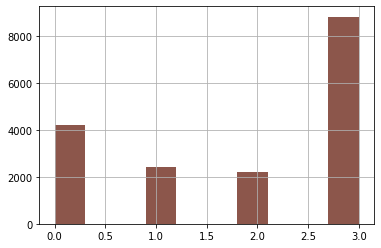

In [70]:
lgb_model = Lgb_Model(reduce_train, ajusted_test, features_copy, categoricals=categoricals)

In [27]:
features_copy = features.copy()
features_copy = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features_copy].shape, ajusted_test.shape, len(features_copy), categoricals

((17690, 563), (1000, 1032), 563, ['session_title'])

|   iter    |  target   | colsam... |   gamma   | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
[0]	train-rmse:1.72839	val-rmse:1.74187
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.53262	val-rmse:1.02487
Stopping. Best iteration:
[31]	train-rmse:0.644028	val-rmse:1.01893

Partial score of fold 0 is: 0.5480116049453271
[0]	train-rmse:1.72815	val-rmse:1.74038
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.533375	val-rmse:1.00539
Stopping. Best iteration:
[32]	train-rmse:0.640448	val-rmse:1.00068

Partial score of fold 1 is: 0.5734202954036658
[0]	train-rmse:1.72801	val-rmse:1.74035
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.370698	val-rmse:1.01294
Stopping. Best iteration:
[60]	train-rmse:0.460519	val-rmse:1.00833

Partial score of fold 4 is: 0.5680346371047764
|  4        |  0.5648   |  0.4304   |  0.09151  |  0.2321   |  10.51    |  0.1693   |  0.9888   |
[0]	train-rmse:1.73318	val-rmse:1.74044
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.808353	val-rmse:0.999984
Stopping. Best iteration:
[53]	train-rmse:0.808367	val-rmse:0.999974

Partial score of fold 0 is: 0.5699797865225346
[0]	train-rmse:1.73253	val-rmse:1.73965
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.803609	val-rmse:0.990984
Stopping. Best iteration:
[67]	train-rmse:0.80361	val-rmse:0.990984

Partial score of fold 1 is: 0.5868403783922249
[

[200]	train-rmse:0.969232	val-rmse:0.990695
[300]	train-rmse:0.954755	val-rmse:0.991745
Stopping. Best iteration:
[222]	train-rmse:0.96578	val-rmse:0.990253

Partial score of fold 4 is: 0.5883477184569403
|  8        |  0.582    |  1.0      |  0.8721   |  0.0      |  2.0      |  20.0     |  0.4      |
[0]	train-rmse:1.74636	val-rmse:1.74668
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.956244	val-rmse:1.00424
[200]	train-rmse:0.935878	val-rmse:1.00316
Stopping. Best iteration:
[157]	train-rmse:0.942827	val-rmse:1.00214

Partial score of fold 0 is: 0.5698416066067167
[0]	train-rmse:1.7466	val-rmse:1.74702
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.958186	val-rmse:1.00065
[200]	train-rmse:0.937632	val-rmse:0.998078
[300]	train-rmse:0.926042	val-rmse:0.997648


[100]	train-rmse:0.990296	val-rmse:0.997093
[200]	train-rmse:0.973832	val-rmse:0.992775
[300]	train-rmse:0.970488	val-rmse:0.991651
Stopping. Best iteration:
[244]	train-rmse:0.970828	val-rmse:0.991545

Partial score of fold 3 is: 0.5877350505914622
[0]	train-rmse:1.74914	val-rmse:1.74809
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.988899	val-rmse:1.00016
[200]	train-rmse:0.974256	val-rmse:0.995332
[300]	train-rmse:0.971806	val-rmse:0.994475
Stopping. Best iteration:
[273]	train-rmse:0.971806	val-rmse:0.994475

Partial score of fold 4 is: 0.5859325183102964
|  12       |  0.5795   |  0.9542   |  7.089    |  8.917    |  2.116    |  0.6587   |  0.9907   |
[0]	train-rmse:1.74851	val-rmse:1.74876
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.986682	val-rmse:1.01

Partial score of fold 4 is: 0.5900490309875659
|  15       |  0.5852   |  0.9693   |  3.366    |  0.2146   |  2.604    |  4.048    |  0.881    |
[0]	train-rmse:1.7487	val-rmse:1.74892
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.986604	val-rmse:1.01215
[200]	train-rmse:0.966238	val-rmse:1.00883
Stopping. Best iteration:
[161]	train-rmse:0.972833	val-rmse:1.00853

Partial score of fold 0 is: 0.5673365244488523
[0]	train-rmse:1.74937	val-rmse:1.74973
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.988114	val-rmse:1.01321
[200]	train-rmse:0.968207	val-rmse:1.00625
[300]	train-rmse:0.954537	val-rmse:1.00241
[400]	train-rmse:0.943298	val-rmse:1.00143
Stopping. Best iteration:
[394]	train-rmse:0.943859	val-rmse:1.00129

Partial score of fold 1 is: 0.5882718539110046


Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.823046	val-rmse:0.992612
[200]	train-rmse:0.807389	val-rmse:0.993187
Stopping. Best iteration:
[115]	train-rmse:0.821128	val-rmse:0.992455

Partial score of fold 1 is: 0.5864825095125301
[0]	train-rmse:1.73568	val-rmse:1.74047
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.822926	val-rmse:0.990449
Stopping. Best iteration:
[77]	train-rmse:0.828599	val-rmse:0.990297

Partial score of fold 2 is: 0.5925662804673435
[0]	train-rmse:1.7356	val-rmse:1.74117
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.821407	val-rmse:0.981241
Stopping. Best iteration:
[96]	train-rmse:0.822355	val-rmse:0.981055

Partial score 

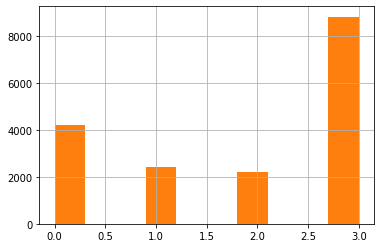

In [34]:
# # Comment out any parameter you don't want to test
# def XGB_CV(
#           max_depth,
#           gamma,
#           min_child_weight,
#           max_delta_step,
#           subsample,
#           colsample_bytree,
#           target='accuracy_group',
#           verbosity=100
#          ):

#     train_df = reduce_train

#     folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    
#     cv = folds.split(reduce_train, reduce_train[target])
    
#     params = {
#       'booster' : 'gbtree',
#       'max_depth' : int(max_depth),
#       'gamma' : gamma,
#       'eta' : 0.1,
#       'nthread' : 4,
#       'silent' : True,
# #       'eval_metric': 'auc',
#       'subsample' : max(min(subsample, 1), 0),
#       'colsample_bytree' : max(min(colsample_bytree, 1), 0),
#       'min_child_weight' : min_child_weight,
#       'max_delta_step' : int(max_delta_step),
#       'seed' : 1001,
#       'objective':'reg:squarederror',
#     }
    
    
#     oof_pred = np.zeros(train_df.shape[0])
#     for fold, (train_idx, val_idx) in enumerate(cv):
        
#         x_train, x_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]   
#         y_train, y_val = train_df[target][train_idx], train_df[target][val_idx]

#         train_set = xgb.DMatrix(x_train, y_train)
#         val_set = xgb.DMatrix(x_val, y_val)
        
#         clf = xgb.train(params, 
#                          train_set, 
#                          num_boost_round=5000, 
#                          evals=[(train_set, 'train'), 
#                                 (val_set, 'val')], 
#                          verbose_eval=verbosity,
#                          early_stopping_rounds=100)
        
#         oof_pred[val_idx] = clf.predict(xgb.DMatrix(train_df.iloc[val_idx][features]))

#         print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        
#         del clf, train_idx, val_idx
#         gc.collect()
#     _, loss_score, _ = eval_qwk_lgb_regr(train_df[target], oof_pred)    
#     print('Our oof cohen kappa score is: ', loss_score)

# #     return -mean_squared_error(oof, target)**0.5
#     return loss_score

    
# XGB_BO = BayesianOptimization(XGB_CV, {
#                                      'max_depth': (2, 12),
#                                      'gamma': (0.001, 10.0),
#                                      'min_child_weight': (0, 20),
#                                      'max_delta_step': (0, 10),
#                                      'subsample': (0.4, 1.0),
#                                      'colsample_bytree' :(0.4, 1.0)
#                                     })

# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
#     XGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)

In [35]:
# print('-'*130)
# print('Final Results')
# print('Maximum  value: %f' % XGB_BO.max['target'])
# print('Best  parameters:', XGB_BO.max['params'])



# if XGB_BO.max['target'] > 0.592347:
#     XGB_params = XGB_BO.max['params']
# else:
#     XGB_params = {
#     'colsample_bytree': 0.5718422563102614,
#     'gamma': 9.121035497281943,
#     'max_delta_step': 1.070668157937703, 
#     'max_depth': 8.29419083806185, 
#     'min_child_weight': 0.6493316414338923,
#     'subsample': 0.6592648167510096}
    
# # Maximum  value: 0.592347   # 0.538
# # Best  parameters: {
# #     'colsample_bytree': 0.5718422563102614,
# #     'gamma': 9.121035497281943,
# #     'max_delta_step': 1.070668157937703, 
# #     'max_depth': 8.29419083806185, 
# #     'min_child_weight': 0.6493316414338923,
# #     'subsample': 0.6592648167510096}

----------------------------------------------------------------------------------------------------------------------------------
Final Results
Maximum  value: 0.591166
Best  parameters: {'colsample_bytree': 0.8385855877831687, 'gamma': 9.78703082065715, 'max_delta_step': 9.978971185581143, 'max_depth': 5.788939386673138, 'min_child_weight': 19.371617583426954, 'subsample': 0.9390899087314895}


[0]	train-rmse:1.86271	val-rmse:1.86285
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.21261	val-rmse:1.24397
[200]	train-rmse:0.962815	val-rmse:1.04086
[300]	train-rmse:0.897218	val-rmse:1.00011
[400]	train-rmse:0.87133	val-rmse:0.989685
[500]	train-rmse:0.858957	val-rmse:0.986451
[600]	train-rmse:0.85072	val-rmse:0.985238
[700]	train-rmse:0.845792	val-rmse:0.984819
[800]	train-rmse:0.841935	val-rmse:0.98465
[900]	train-rmse:0.839323	val-rmse:0.984357
[1000]	train-rmse:0.836656	val-rmse:0.984295
[1100]	train-rmse:0.83413	val-rmse:0.984006
[1200]	train-rmse:0.832198	val-rmse:0.984011
[1300]	train-rmse:0.830424	val-rmse:0.983873
[1400]	train-rmse:0.828506	val-rmse:0.983769
[1500]	train-rmse:0.826591	val-rmse:0.983751
[1600]	train-rmse:0.825329	val-rmse:0.983565
[1700]	train-rmse:0.823976	val-rmse:0.983533
[1800]	train-rmse:0.822654	val-rmse:0.983426
[1900]	train-rmse:0.82103

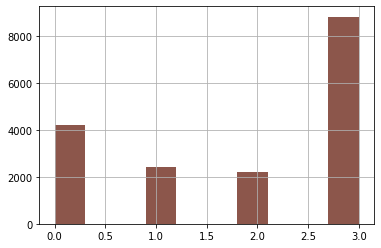

In [36]:
xgb_model = Xgb_Model(reduce_train, ajusted_test, features_copy, categoricals=categoricals, params=XGB_params)

In [42]:
final_pred = lgb_model.y_pred * 0.8 + xgb_model.y_pred * 0.2

{0: 1.4827951869746674, 1: 1.9164307153342817, 2: 2.1240703704860424}


3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64

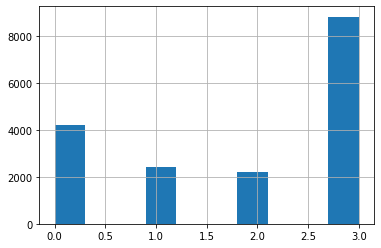

In [43]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

# lgb_model
# bound[0] = 1.18253215
# bound[1] = 1.81532098
# bound[2] = 2.17071483

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)